### Prerequisities

Install and import libraries, use cuda if available, and set a manual seed for reproducibility.

In [1]:
!pip install captum

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, models
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial

from sklearn.metrics import confusion_matrix

from captum.attr import Occlusion
from captum.attr import visualization as viz

use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

torch.manual_seed(5507)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.0 MB/s eta 0:00:0000:010:01


### Load the Data

#### Create Dataset

Create a custom Dataset class for the cancer data.

In [2]:
class ImageDataset(Dataset):
    
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = read_image(img_path)
        label = self.data.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

#### Calculate Mean and Standard Deviation
Get the mean and standard deviation of the images using a data loader so the images can be normalized in a transform.

In [3]:
def get_mean_and_std(data_loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, labels in data_loader:
        batch, channel, height, width = images.shape
        nb_pixels = batch * height * width
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean, std

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
image_dataset = ImageDataset(
    csv_file = '/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
    root_dir = '/kaggle/input/deep-learning-for-msc-2022-23/train/',
    transform = transform
)
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=0)
mean, std = get_mean_and_std(image_loader)

print('mean:', mean)
print('std:', std)

mean: tensor([0.7594, 0.6156, 0.8212])
std: tensor([0.1733, 0.1982, 0.1179])


#### Load Images

Load the images using a DataLoader and perform transformations.

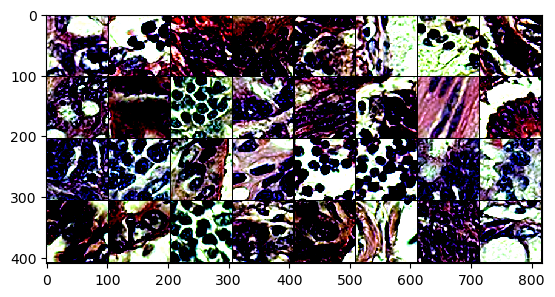

In [4]:
mean = [0.7594, 0.6156, 0.8212]
std = [0.1733, 0.1982, 0.1179]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

image_dataset = ImageDataset(
    csv_file = '/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
    root_dir = '/kaggle/input/deep-learning-for-msc-2022-23/train/',
    transform = transform
)

train_dataset, val_dataset = random_split(image_dataset, [int(len(image_dataset)*0.7), int(len(image_dataset)*0.3)]) 
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=0)

images, labels = next(iter(image_loader))
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), interpolation='nearest')

Because the images have been normalized,they look different to the original images.

#### Create Helper Functions

Create a function to generate a graph for plotting loss and accuracies and a function to generate a confusion matrix.

In [5]:
def generate_graph(train_values, val_values, metric):
    plt.plot(train_values)
    plt.plot(val_values)
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend(['Training','Validation'])
    plt.title(f'Training {metric} vs Validation {metric}')
    plt.show()

def generate_confusion_matrix(y_true, y_pred):
    classes = ['Normal', 'Cancer', 'Muscle', 'Immune']
    conf_matr = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8,6), dpi=100)
    sns.set(font_scale = 1.1)
    ax = sns.heatmap(conf_matr, annot=True, fmt='d', )
    
    ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(classes)

    ax.set_ylabel("Actual", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(classes)

    ax.set_title("Confusion Matrix", fontsize=14, pad=20)

    plt.show()

#### Create Test Function

Create a test function that tests on the test set and creates the submission.csv file.

In [7]:
def perform_test(model):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    test_dir = '/kaggle/input/deep-learning-for-msc-2022-23/test/'
    filenames = []
    preds = []
    with torch.no_grad():
        for filename in range(10001,15042):
            img_path = os.path.join(test_dir, str(filename) + '.png')
            image = read_image(img_path)
            image = transform(image)
            image = image[None,:].to(device=device, dtype=torch.float)
            output = model(image)
            filenames.append(str(filename) + '.png')
            preds.append(output.argmax().tolist())

    submission = pd.DataFrame({
        'Filename': filenames,
        'Label': preds
    })
    submission.to_csv('submission.csv', index=False)

#### Create Trainer Function

Create a robust trainer function that trains on the training dataset, validates on the validation dataset, given the parameters. Finally, it generates the graphs and confusion matrices.

In [8]:
def trainer(model, device, train_dataset, val_dataset, n_epochs, batch_size, lr, weight_decay=0, momentum=0):
    
    # Create train and val loaders using given batch size.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Create optimizer and loss function using given parameters.
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Train over the number of epochs.
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        train_correct = 0
        train_preds = []
        model.train()
        for images, labels in train_loader:
            labels = labels.to(device)
            
            output = model(images.to(device))
            loss = loss_fn(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += F.cross_entropy(output, labels, reduction='sum').item()
            train_pred = output.argmax(dim=1, keepdim=True)
            train_preds += train_pred.flatten().tolist()
            train_correct += train_pred.eq(labels.view_as(train_pred)).sum().item()
            
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100. * train_correct / len(train_loader.dataset)
        
        # Evaluate over the validation set for each epoch.
        model.eval() 
        val_loss = 0.0
        val_correct = 0
        val_preds = []
        val_trues = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.to(device)

                output = model(images.to(device))
                val_loss += F.cross_entropy(output, labels, reduction='sum').item()
                val_pred = output.argmax(dim=1, keepdim=True)
                val_preds += val_pred.flatten().tolist()
                val_trues += labels.view_as(val_pred).flatten().tolist()
                val_correct += val_pred.eq(labels.view_as(val_pred)).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * val_correct / len(val_loader.dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print('Epoch: {}, Train Loss: {:.3f}, Train Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Accuracy: {:.3f}'.format(
            epoch, train_loss, train_accuracy, val_loss, val_accuracy
        ))
    
    # Plot the losses graph.
    generate_graph(train_losses, val_losses, 'Loss')
    generate_graph(train_accuracies, val_accuracies, 'Accuracy')
    generate_confusion_matrix(val_trues, val_preds)

#### Create Ray Tune Function

Create a robust trainer function using ray tune that trains a given model using a given configuration.

In [8]:
def trainer_raytune(config, checkpoint_dir, model, train_dataset, val_dataset):
    n_epochs = 10
    
    device = 'cpu'
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], momentum=config['momentum'])
    loss_fn = nn.CrossEntropyLoss()
    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, 'checkpoint'))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=8)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        train_correct = 0
        train_preds = []
        model.train()
        for images, labels in train_loader:
            labels = labels.to(device)
            
            output = model(images.to(device))
            loss = loss_fn(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += F.cross_entropy(output, labels, reduction='sum').item()
            train_pred = output.argmax(dim=1, keepdim=True)
            train_preds += train_pred.flatten().tolist()
            train_correct += train_pred.eq(labels.view_as(train_pred)).sum().item()
            
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100. * train_correct / len(train_loader.dataset)
        
        # Evaluate over the validation set for each epoch.
        model.eval() 
        val_loss = 0.0
        val_correct = 0
        val_preds = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.to(device)

                output = model(images.to(device))
                val_loss += F.cross_entropy(output, labels, reduction='sum').item()
                val_pred = output.argmax(dim=1, keepdim=True)
                val_preds += val_pred.flatten().tolist()
                val_correct += val_pred.eq(labels.view_as(val_pred)).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * val_correct / len(val_loader.dataset)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print('Epoch: {}, Train Loss: {:.3f}, Train Accuracy: {:.3f}, Validation Loss: {:.3f}, Validation Accuracy: {:.3f}'.format(
            epoch, train_loss, train_accuracy, val_loss, val_accuracy
        ))
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
                path = os.path.join(checkpoint_dir, "checkpoint")
                torch.save((model.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=val_loss, accuracy=val_accuracy)
    
    print('Finished training.')

### Model 1 (CNN From Scratch)

Create a function that creates a CNN from scratch. The input is three channels for each image due to RGB. The convolutional nets go from 3 to 128 and then halve until the last Flatten and Linear functions. ReLu is the activation function for each layer and a max-pooling of size 2 is done after each layer. A padding of 1 is applied to Conv.

In [5]:
def create_new_model():
    return nn.Sequential(collections.OrderedDict([
              ('conv1', nn.Conv2d(3,128,3,padding=1)),
              ('relu1', nn.ReLU()),
              ('maxpool1', nn.MaxPool2d(2,2)),
              ('conv2', nn.Conv2d(128,64,3,padding=1)),
              ('relu2', nn.ReLU()),
              ('maxpool2', nn.MaxPool2d(2,2)),
              ('conv3', nn.Conv2d(64,32,3,padding=1)),
              ('relu3', nn.ReLU()),
              ('maxpool3', nn.MaxPool2d(2,2)),
              ('flatten', nn.Flatten()),
              ('fc1', nn.Linear(32*12*12,4))
            ]))

#### Raytuning on Model 1

Create a main method to perform raytuning. The configuration options include four parameters as follows.

* `batch_size`: 16, 32, or 64, where 32 is the most common. Increasing the batch size can make the training fast, but can reduce the generalizability.
* `lr`: 0.01, 0.001, 0.0001, ranging from a fairly large learning rate to a low learning rate. Smaller learning rates are slow to converge but can lead to better results.
* `weight_decay`: 0.00001, 0.001, 0.1, 0, varying the l2 regularization amount. 0 means no regularization.
* `momentum`: 0.99, 0.9, 0.5, or 0, varying the momentum. 

In [143]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "batch_size": tune.choice([16,32,64]),
        "lr": tune.choice([0.01,0.001,0.0001]),
        "weight_decay": tune.choice([0.00001,0.001,0.1,0]),
        "momentum": tune.choice([0.99,0.9,0.5,0]),
        }
    
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )
    
    reporter = CLIReporter(
        parameter_columns=["batch_size", "lr", "weight_decay", "momentum"],
        metric_columns=["loss", "accuracy", "training_iteration"]
    )
    
    model = create_new_model()
    
    result = tune.run(
        partial(
            trainer_raytune,
            model = model,
            train_dataset=train_dataset,
            val_dataset=val_dataset
        ),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
            best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
            best_trial.last_result["accuracy"]))

    best_trained_model = create_new_model()
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
            best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

#     test_accuracy_and_submit(best_trained_model)

#     return best_trained_model

if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    best_trained_model = main(num_samples=10, max_num_epochs=15, gpus_per_trial=0.5)

== Status ==
Current time: 2023-03-26 22:19:01 (running for 00:00:00.25)
Memory usage on this node: 4.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------|
| trainer_raytune_35d5f_00000 | RUNNING  | 172.19.2.2:60815 |           32 | 0.01   |          0.1   |       0.99 |
| trainer_raytune_35d5f_00001 | PENDING  |                  |           

(func pid=60815) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=60815)   cpuset_checked))
(func pid=60815) E0326 22:19:08.276778236   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=60815) E0326 22:19:08.464729380   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:19:11 (running for 00:00:10.24)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------|
| trainer_raytune_35d5f_00000 | RUNNING  | 172.19.2.2:60815 |           32 | 0.01   |          0.1   |       0.99 |
| trainer_raytune_35d5f_00001 | PENDING  |                  |           

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainer_raytune_35d5f_00000,8.90653,2023-03-26_22-21-16,True,,9d74bd6a89be4498a98ec73edf4ef8f0,37be2df01555,10,nan,172.19.2.2,60815,True,129.973,12.6327,129.973,1679869276,0,,10,35d5f_00000,0.00892925
trainer_raytune_35d5f_00001,85.8466,2023-03-26_22-23-29,True,,d8722a3b33a846dc89119f89102cba1a,37be2df01555,10,0.408137,172.19.2.2,62793,True,126.566,12.9395,126.566,1679869409,0,,10,35d5f_00001,0.00760698
trainer_raytune_35d5f_00002,91.5785,2023-03-26_22-25-54,True,,caf02706dd354132bd324e5cbd5c16c7,37be2df01555,10,0.230293,172.19.2.2,64775,True,139.202,13.2961,139.202,1679869554,0,,10,35d5f_00002,0.00498748
trainer_raytune_35d5f_00003,53.0864,2023-03-26_22-26-16,True,,3096317cc8ff432f97f5e436ef80237d,37be2df01555,1,1.23441,172.19.2.2,66737,True,17.4299,17.4299,17.4299,1679869576,0,,1,35d5f_00003,0.00645232
trainer_raytune_35d5f_00004,58.3333,2023-03-26_22-26-39,True,,71a927e0606841b9af1f55c005c077ea,37be2df01555,1,1.03345,172.19.2.2,66964,True,17.5336,17.5336,17.5336,1679869599,0,,1,35d5f_00004,0.00562358
trainer_raytune_35d5f_00005,77.1164,2023-03-26_22-27-16,True,,05c3ae095584409baeed42e6ae9882b3,37be2df01555,2,0.718283,172.19.2.2,67184,True,31.2155,13.8757,31.2155,1679869636,0,,2,35d5f_00005,0.00543499
trainer_raytune_35d5f_00006,91.1817,2023-03-26_22-29-30,True,,e37d35efa6a44a07b90a4738eda2d271,37be2df01555,10,0.292928,172.19.2.2,67605,True,127.659,12.8926,127.659,1679869770,0,,10,35d5f_00006,0.00584173
trainer_raytune_35d5f_00007,88.5802,2023-03-26_22-31-29,True,,373e70054f1e4b70ad04c2f9d085e8fd,37be2df01555,8,0.385633,172.19.2.2,69497,True,113.865,14.1135,113.865,1679869889,0,,8,35d5f_00007,0.00474906
trainer_raytune_35d5f_00008,50.8818,2023-03-26_22-31-50,True,,099b4fd2898242e0afa3fad73b4bfcba,37be2df01555,1,1.10053,172.19.2.2,71043,True,16.0899,16.0899,16.0899,1679869910,0,,1,35d5f_00008,0.00626159
trainer_raytune_35d5f_00009,60.7143,2023-03-26_22-32-13,True,,e2ed3e41e4a14dac83d028d0c3a48245,37be2df01555,1,1.00072,172.19.2.2,71276,True,17.4553,17.4553,17.4553,1679869933,0,,1,35d5f_00009,0.00493145


(func pid=60815) Epoch: 1, Train Loss: 5.361, Train Accuracy: 49.150, Validation Loss: 20.602, Validation Accuracy: 26.896
== Status ==
Current time: 2023-03-26 22:19:28 (running for 00:00:27.57)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+---------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |    loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1376: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


== Status ==
Current time: 2023-03-26 22:19:41 (running for 00:00:39.85)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING 

(func pid=60815) E0326 22:19:44.930045676   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=60815) E0326 22:19:44.977220159   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=60815) E0326 22:19:45.252115825   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:19:46 (running for 00:00:44.86)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING 

(func pid=60815) E0326 22:19:49.141680747   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=60815) E0326 22:19:49.384985531   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:19:54 (running for 00:00:52.90)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING 

(func pid=60815) E0326 22:20:01.386511352   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:20:06 (running for 00:01:05.14)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING  

(func pid=60815) E0326 22:20:23.016936118   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=60815) E0326 22:20:23.056025053   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:20:23 (running for 00:01:22.27)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING  

(func pid=60815) E0326 22:20:26.401501002   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=60815) E0326 22:20:26.487851960   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:20:31 (running for 00:01:30.16)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING  

(func pid=60815) E0326 22:20:38.808993900   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=60815) E0326 22:20:38.849503021   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:20:43 (running for 00:01:42.38)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING  

(func pid=60815) E0326 22:20:47.535952922   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:20:48 (running for 00:01:47.39)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING  

(func pid=60815) E0326 22:21:00.437405183   60856 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:21:01 (running for 00:02:00.51)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status   | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+----------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5f_00000 | RUNNING  |

(func pid=62793) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=62793)   cpuset_checked))
(func pid=62793) E0326 22:21:24.577083639   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:21:27 (running for 00:02:26.49)
Memory usage on this node: 6.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5

(func pid=62793) E0326 22:21:35.170072808   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:21:37 (running for 00:02:36.52)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: nan | Iter 2.000: nan | Iter 1.000: -20.60188239634142
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |   loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+--------+------------+----------------------|
| trainer_raytune_35d5

(func pid=62793) E0326 22:21:51.191930869   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:21:55 (running for 00:02:54.69)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: nan | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |      loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------+------------+----------------------

(func pid=62793) E0326 22:21:59.806047064   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:22:00 (running for 00:02:59.70)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: nan | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |      loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------+------------+----------------------

(func pid=62793) E0326 22:22:03.566955243   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=62793) E0326 22:22:03.789007125   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:22:08 (running for 00:03:07.30)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: nan | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+-------------------

(func pid=62793) E0326 22:22:15.415106208   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=62793) E0326 22:22:15.454742051   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=62793) E0326 22:22:15.537392657   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:22:20 (running for 00:03:19.10)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+--

(func pid=62793) E0326 22:22:23.907627296   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:22:25 (running for 00:03:24.11)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+--

(func pid=62793) E0326 22:22:48.079238464   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:22:49 (running for 00:03:48.28)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+--

(func pid=62793) E0326 22:22:51.756413615   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=62793) E0326 22:22:51.890521379   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:22:56 (running for 00:03:55.36)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+--

(func pid=62793) E0326 22:23:00.575438077   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:23:01 (running for 00:04:00.36)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: nan | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+--

(func pid=62793) E0326 22:23:04.529673149   62827 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:23:09 (running for 00:04:08.09)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------

(func pid=64775) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=64775)   cpuset_checked))
(func pid=64775) E0326 22:23:36.909294355   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:23:40 (running for 00:04:39.12)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------

(func pid=64775) E0326 22:23:48.478091624   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=64775) E0326 22:23:48.563341294   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=64775) E0326 22:23:48.604661260   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:23:50 (running for 00:04:49.16)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -10.51199365503153
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------

(func pid=64775) E0326 22:23:52.612322442   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:23:57 (running for 00:04:56.38)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.599170412336077 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=64775) E0326 22:24:02.732049973   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(func pid=64775) Epoch: 2, Train Loss: 0.418, Train Accuracy: 84.070, Validation Loss: 0.330, Validation Accuracy: 87.213


(func pid=64775) E0326 22:24:06.456820605   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=64775) E0326 22:24:06.589771982   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=64775) E0326 22:24:06.634805338   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:24:11 (running for 00:05:10.09)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+---------

(func pid=64775) E0326 22:24:19.537019028   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:24:24 (running for 00:05:23.12)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.46943765384600067 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+---------

(func pid=64775) E0326 22:24:33.491272980   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:24:38 (running for 00:05:37.00)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=64775) E0326 22:24:42.448397349   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=64775) E0326 22:24:42.689811751   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:24:43 (running for 00:05:42.00)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=64775) E0326 22:24:46.920927692   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:24:51 (running for 00:05:50.37)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=64775) E0326 22:24:55.583849878   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:24:56 (running for 00:05:55.38)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=64775) E0326 22:25:09.854050460   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(func pid=64775) Epoch: 7, Train Loss: 0.230, Train Accuracy: 91.194, Validation Loss: 0.309, Validation Accuracy: 87.081


(func pid=64775) E0326 22:25:13.798274847   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:25:18 (running for 00:06:17.34)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.4333854091651015 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=64775) E0326 22:25:26.945371518   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=64775) E0326 22:25:26.993786167   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:25:31 (running for 00:06:30.47)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=64775) E0326 22:25:36.725045480   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=64775) E0326 22:25:36.809678839   64810 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(func pid=64775) Epoch: 9, Train Loss: 0.178, Train Accuracy: 93.651, Validation Loss: 0.289, Validation Accuracy: 88.316
== Status ==
Current time: 2023-03-26 22:25:46 (running for 00:06:44.76)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|----

(func pid=66737) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=66737)   cpuset_checked))
(func pid=66737) E0326 22:26:01.243387046   66771 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=66737) E0326 22:26:01.387302453   66771 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:26:04 (running for 00:07:03.16)
Memory usage on this node: 6.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=66737) E0326 22:26:12.907449673   66771 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:26:14 (running for 00:07:13.19)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.42210491372163966
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+----------

(func pid=66964) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=66964)   cpuset_checked))
(func pid=66964) E0326 22:26:24.413824792   66999 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=66964) E0326 22:26:24.471092299   66999 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:26:27 (running for 00:07:26.15)
Memory usage on this node: 6.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.8282594054254064
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=66964) E0326 22:26:35.475814464   66999 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=66964) E0326 22:26:35.734503661   66999 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=66964) E0326 22:26:35.785206174   66999 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:26:37 (running for 00:07:36.18)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.8282594054254064
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67184) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=67184)   cpuset_checked))
(func pid=67184) E0326 22:26:47.364703828   67218 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:26:50 (running for 00:07:49.15)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -1.0334509272634247
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67184) E0326 22:26:58.975484338   67218 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67184) E0326 22:26:59.045599199   67218 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:27:00 (running for 00:07:59.18)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -1.0334509272634247
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67184) E0326 22:27:02.584577614   67218 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:27:07 (running for 00:08:06.35)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -1.001737894414804
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------

(func pid=67605) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=67605)   cpuset_checked))
(func pid=67605) E0326 22:27:24.220464285   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:27:24.408798543   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:27:27 (running for 00:08:26.17)
Memory usage on this node: 6.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.599170412336077 | Iter 1.000: -1.001737894414804
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+

(func pid=67605) E0326 22:27:34.914609749   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:27:35.080338041   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:27:37 (running for 00:08:36.20)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.599170412336077 | Iter 1.000: -1.001737894414804
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+

(func pid=67605) E0326 22:27:38.485265897   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:27:38.601574181   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:27:38.682042923   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:27:38.852846527   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:27:43 (running for 00:08:42.26)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.599170412336077 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------

(func pid=67605) E0326 22:27:47.760315263   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:27:48 (running for 00:08:47.27)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.599170412336077 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------

(func pid=67605) E0326 22:27:51.354926529   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:27:56 (running for 00:08:55.02)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:27:59.834800477   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:28:01 (running for 00:09:00.03)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:28:03.895784871   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:28:08 (running for 00:09:07.48)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:28:11.589670900   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:28:13 (running for 00:09:12.50)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.4240191800805627 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:28:16.389233783   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:28:16.523811399   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:28:16.566915805   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:28:21 (running for 00:09:20.15)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:28:24.684797046   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:28:26 (running for 00:09:25.16)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:28:36.870963272   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:28:38 (running for 00:09:37.12)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:28:53.117828343   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:28:53.277258784   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:28:58 (running for 00:09:56.88)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:29:01.457820929   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:29:01.633671546   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:29:03 (running for 00:10:01.89)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.3520177125510295 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:29:05.127087116   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:29:05.264428599   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:29:05.394772046   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:29:10 (running for 00:10:08.90)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:29:17.144053281   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:29:17.307603108   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:29:17.373243163   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:29:17.458434484   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=67605) E0326 22:29:17.651855433   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:29:22 (running for 00:10:20.91)
Memory usage on this node: 7.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=67605) E0326 22:29:26.559225794   67646 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:29:27 (running for 00:10:25.92)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=69497)   cpuset_checked))
(func pid=69497) E0326 22:29:37.147808841   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:29:40 (running for 00:10:39.20)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:29:48.832964535   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:29:50 (running for 00:10:49.23)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:29:53.884088104   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:29:58 (running for 00:10:57.41)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:30:02.726800875   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:30:03 (running for 00:11:02.42)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4644559881595708 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:30:06.914878342   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:30:07.190392432   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:30:11 (running for 00:11:10.68)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:30:16.243589421   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:30:16.473003048   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:30:16 (running for 00:11:15.69)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:30:20.115037719   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:30:25 (running for 00:11:23.88)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3786007063151247 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:30:30.437538569   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:30:30.531110457   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(func pid=69497) Epoch: 4, Train Loss: 0.294, Train Accuracy: 89.512, Validation Loss: 0.316, Validation Accuracy: 88.492


(func pid=69497) E0326 22:30:34.138041962   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:30:34.422798441   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:30:39 (running for 00:11:37.86)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:30:47.523422073   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:30:52 (running for 00:11:51.29)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:30:57.650945559   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:30:57.747797143   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:30:57.824398544   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


(func pid=69497) Epoch: 6, Train Loss: 0.220, Train Accuracy: 91.648, Validation Loss: 0.303, Validation Accuracy: 89.550


(func pid=69497) E0326 22:31:01.769853162   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:31:06 (running for 00:12:05.54)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:31:15.337039299   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:31:20 (running for 00:12:18.88)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=69497) E0326 22:31:24.694897673   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:31:24.752107386   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:31:24.852465539   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=69497) E0326 22:31:24.925877551   69536 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:31:25 (running for 00:12:23.90)
Memory usage on this node: 7.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.2706500159369575 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=71043) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=71043)   cpuset_checked))
(func pid=71043) E0326 22:31:36.429274348   71083 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=71043) E0326 22:31:36.570970141   71083 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:31:39 (running for 00:12:38.38)
Memory usage on this node: 6.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 8.000: -0.3281416561704201 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.6960648876439117
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+-----------

(func pid=71276) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=71276)   cpuset_checked))
(func pid=71276) E0326 22:31:58.723583561   71316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=71276) E0326 22:31:58.810691542   71316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:32:01 (running for 00:13:00.23)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.3281416561704201 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+---------

(func pid=71276) E0326 22:32:10.325804526   71316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=71276) E0326 22:32:10.366521841   71316 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-26 22:32:11 (running for 00:13:10.26)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.3281416561704201 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.9700248615661836
Resources requested: 2.0/2 CPUs, 0.5/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+---------

2023-03-26 22:32:14,019	INFO tune.py:763 -- Total run time: 792.80 seconds (792.63 seconds for the tuning loop).


== Status ==
Current time: 2023-03-26 22:32:13 (running for 00:13:12.65)
Memory usage on this node: 6.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.3281416561704201 | Iter 4.000: -0.3471663558372745 | Iter 2.000: -0.4065071313101568 | Iter 1.000: -0.9853744326024669
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/5.89 GiB heap, 0.0/2.95 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/trainer_raytune_2023-03-26_22-19-01
Number of trials: 10/10 (10 TERMINATED)
+-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------------------+
| Trial name                  | status     | loc              |   batch_size |     lr |   weight_decay |   momentum |       loss |   accuracy |   training_iteration |
|-----------------------------+------------+------------------+--------------+--------+----------------+------------+------------+------------+----------

According to the ray tuning, the best configuration is the following:

* `batch_size`: 16
* `lr`: 0.001
* `weight_decay`: 1e-05
* `momentum`: 0.9

#### Train On Best Configuation for Model 1

Train on the best configuration for model 1. Also show the loss and accuracy graphs and the confusion matrix.

Epoch: 1, Train Loss: 0.684, Train Accuracy: 72.468, Validation Loss: 0.418, Validation Accuracy: 83.862
Epoch: 2, Train Loss: 0.408, Train Accuracy: 84.146, Validation Loss: 0.354, Validation Accuracy: 86.155
Epoch: 3, Train Loss: 0.356, Train Accuracy: 85.828, Validation Loss: 0.343, Validation Accuracy: 86.772
Epoch: 4, Train Loss: 0.296, Train Accuracy: 88.568, Validation Loss: 0.313, Validation Accuracy: 87.169
Epoch: 5, Train Loss: 0.277, Train Accuracy: 89.569, Validation Loss: 0.308, Validation Accuracy: 87.522
Epoch: 6, Train Loss: 0.252, Train Accuracy: 90.155, Validation Loss: 0.304, Validation Accuracy: 88.272
Epoch: 7, Train Loss: 0.221, Train Accuracy: 92.120, Validation Loss: 0.287, Validation Accuracy: 89.330
Epoch: 8, Train Loss: 0.197, Train Accuracy: 93.216, Validation Loss: 0.319, Validation Accuracy: 87.610
Epoch: 9, Train Loss: 0.172, Train Accuracy: 93.859, Validation Loss: 0.313, Validation Accuracy: 88.139
Epoch: 10, Train Loss: 0.166, Train Accuracy: 93.726, V

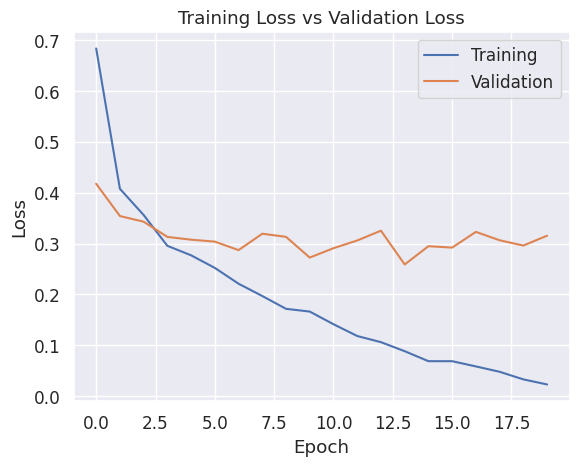

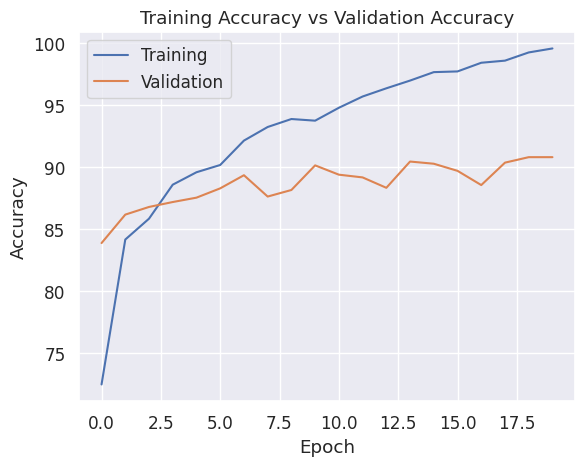

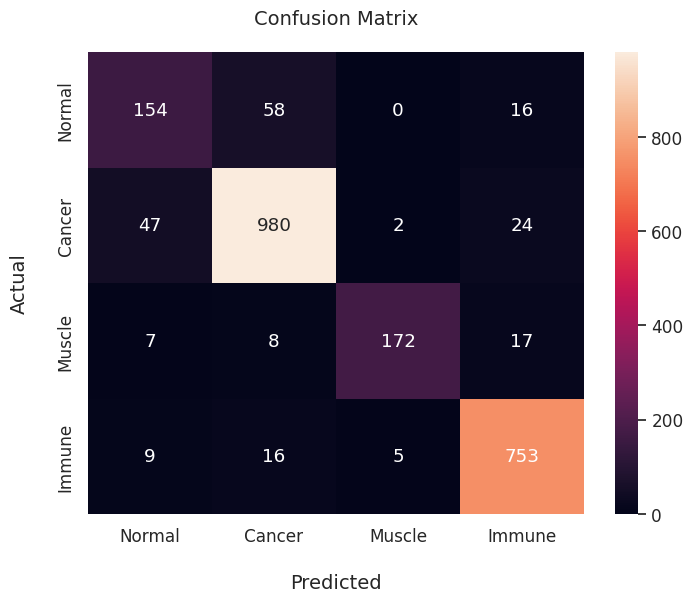

In [171]:
best_config = {
    'batch_size': 16,
    'lr': 0.001,
    'weight_decay': 1e-05,
    'momentum': 0.9
}

model = create_new_model()
trainer(
    model = model,
    device = device,
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    n_epochs = 20,
    batch_size = best_config['batch_size'],
    lr = best_config['lr'],
    weight_decay=best_config['weight_decay'],
    momentum=best_config['momentum']
)

As expected, the training loss decreases and the training accuracy increases as the number of epochs increases. But we can see that initially, validation loss decreseases, but then starts fluctuating around 0.3. This is because the model isn't generalizing better anymore, but only overfitting on the training set, which is not a good practice. Similarly for the same reason, the training accuracy shoots up and keeps increasing, while the validation accuracy only slowly increases.

The confusion matrix shows the the general classification is very good in most cases. There is an imbalance with the data where there are many more immune cells which are very accurately predicted too. The cancel cells are very well classified too, but the errors can be fixed using data augmentation to fix the data imbalance.

#### Using Occlusion-Based Attribution Using Captum for Model 1

Using Occulusion to determine which parts of the image are critical to classifier's decision-making.

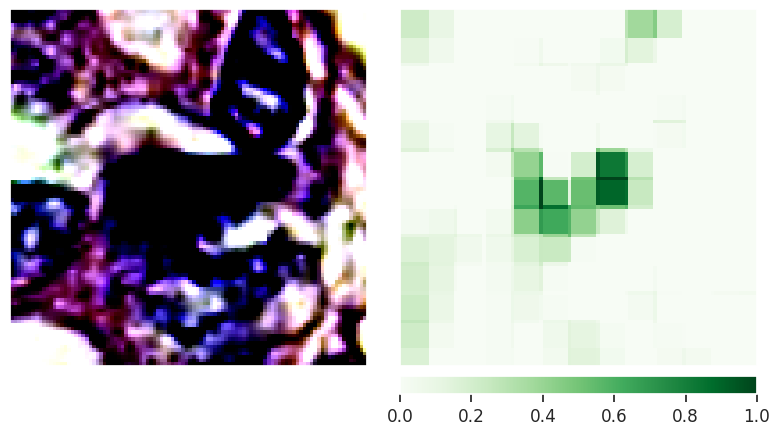

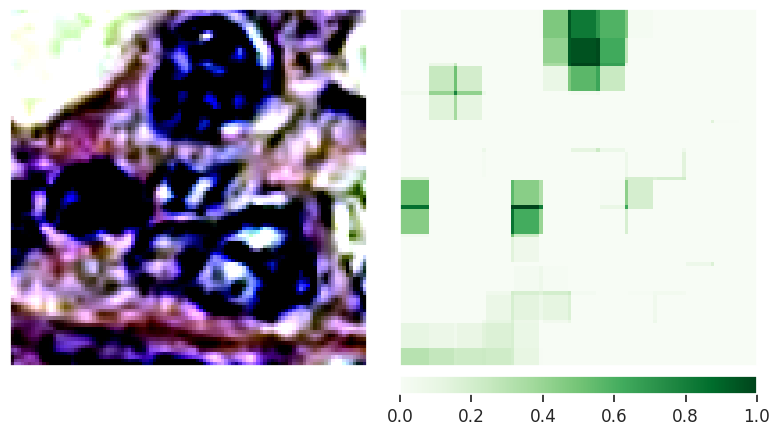

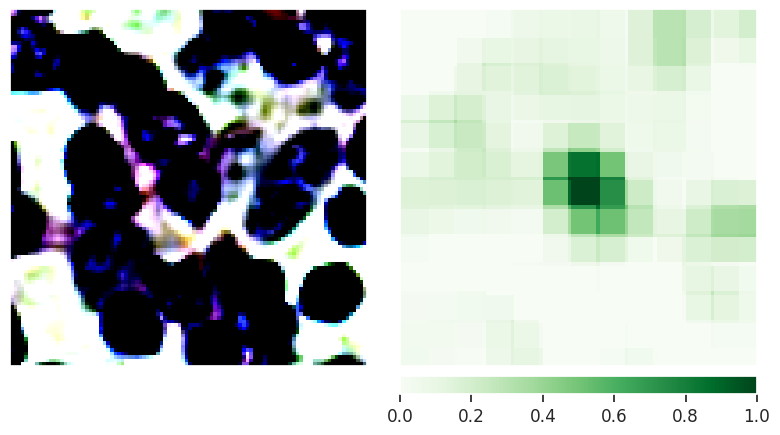

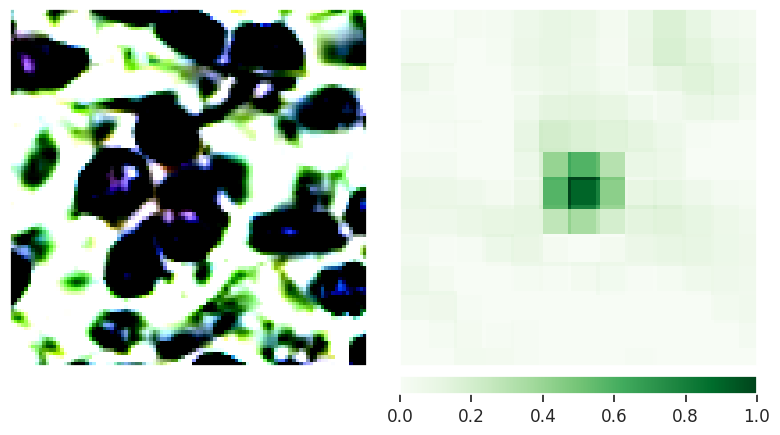

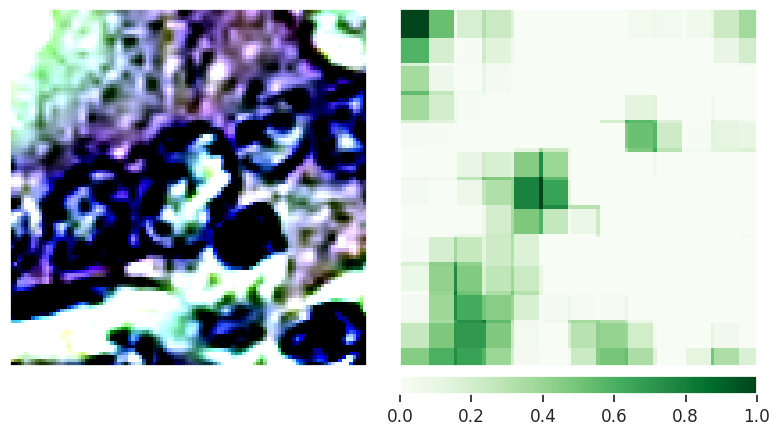

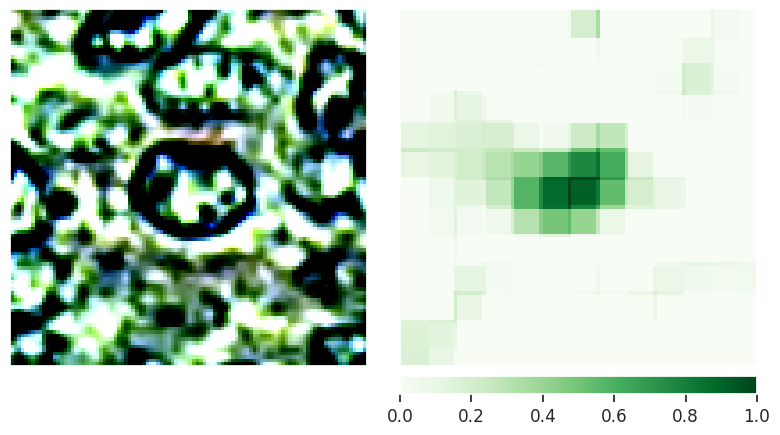

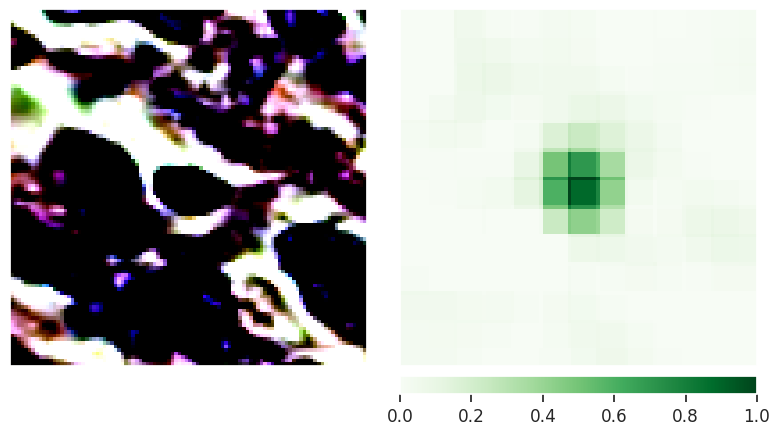

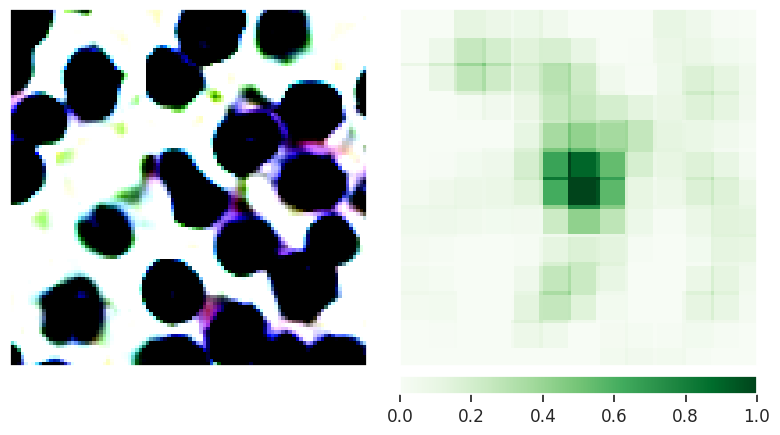

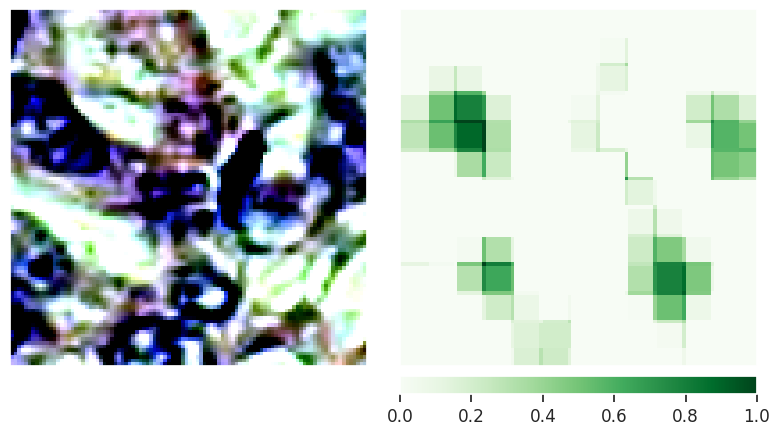

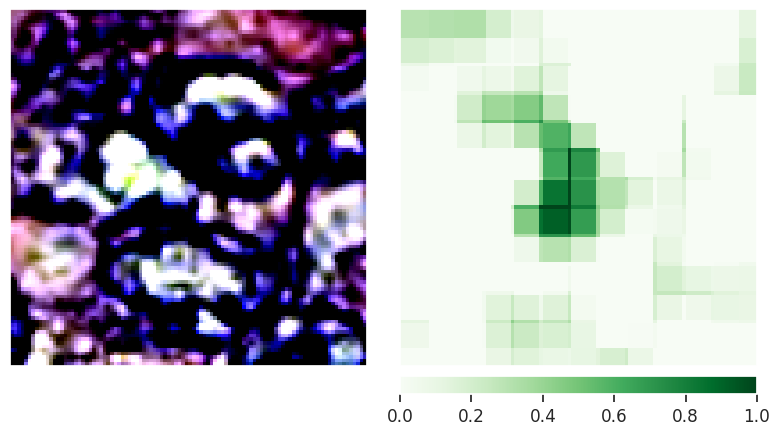

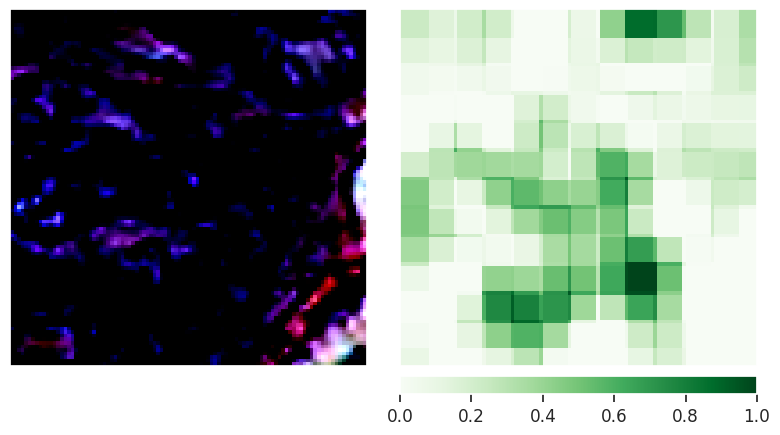

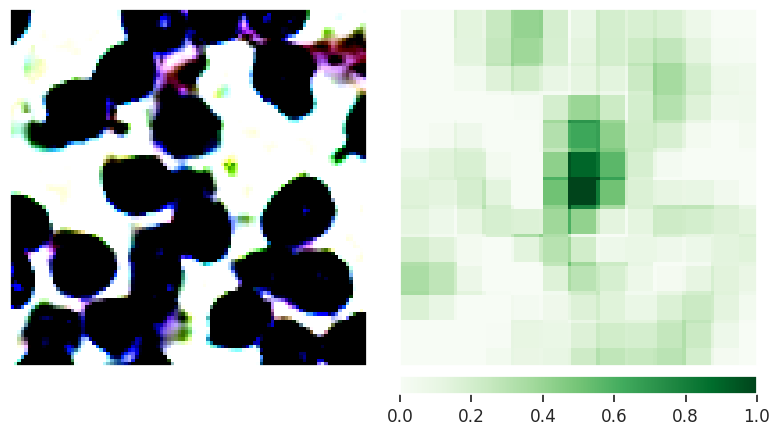

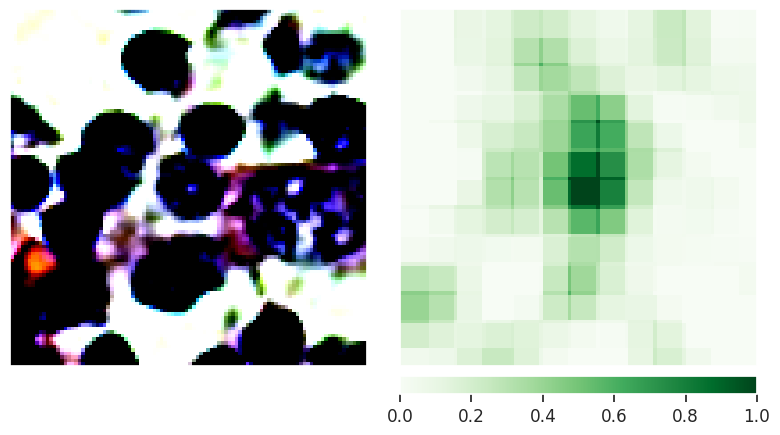

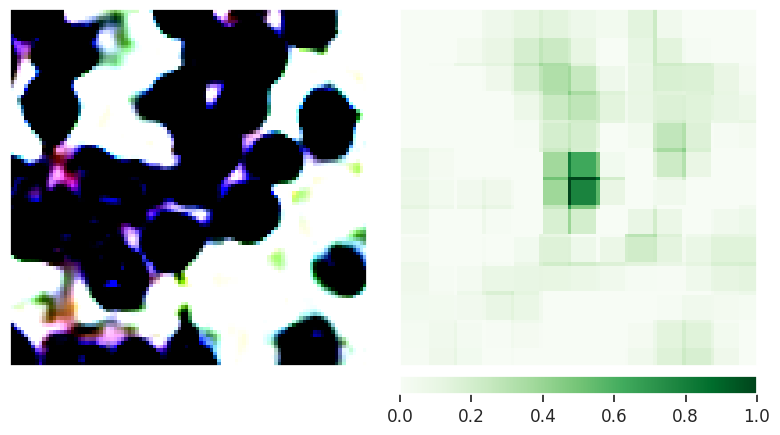

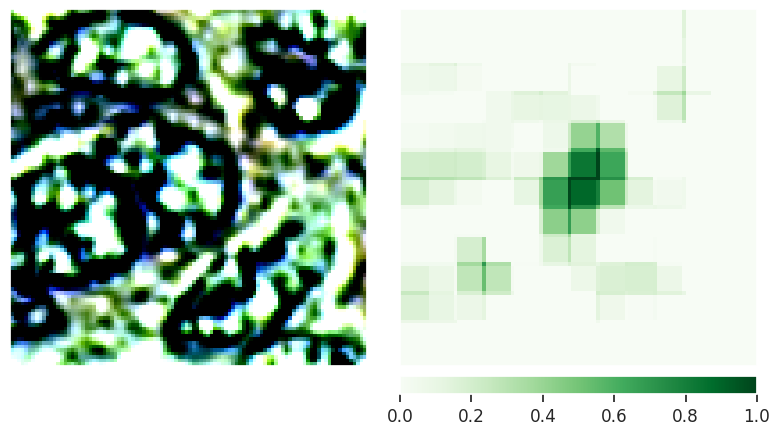

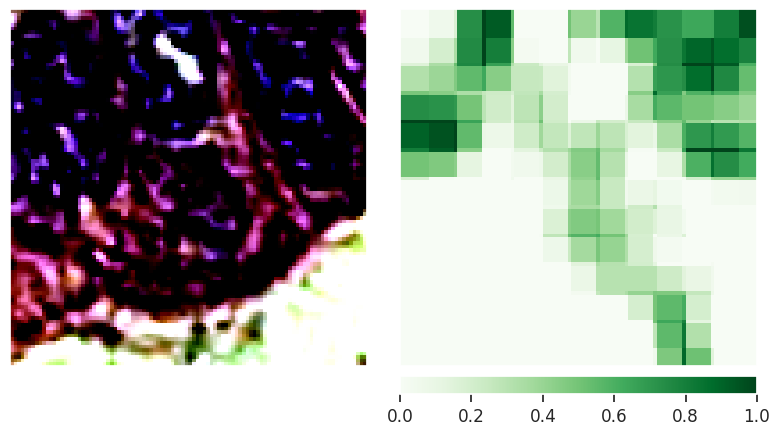

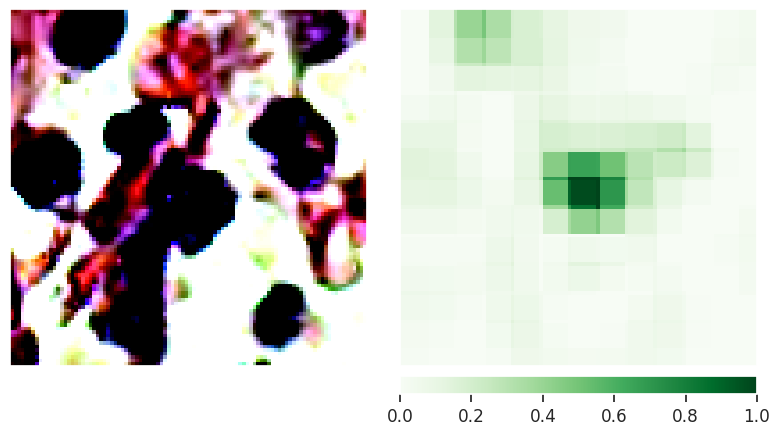

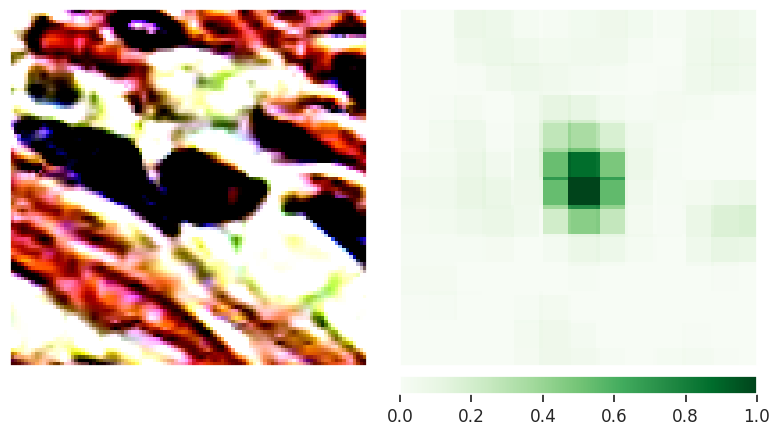

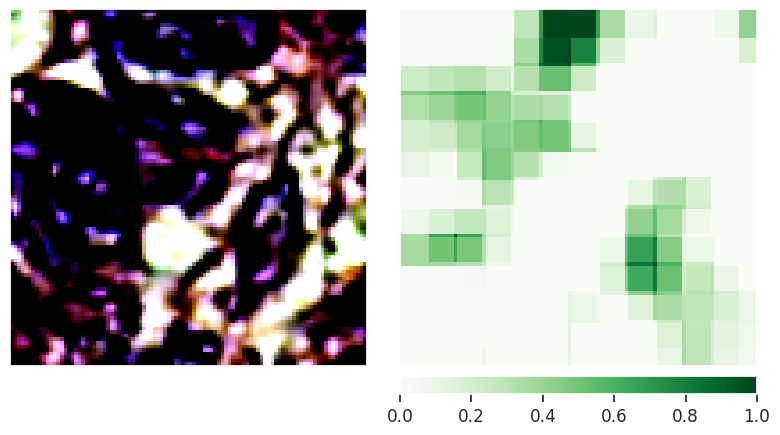

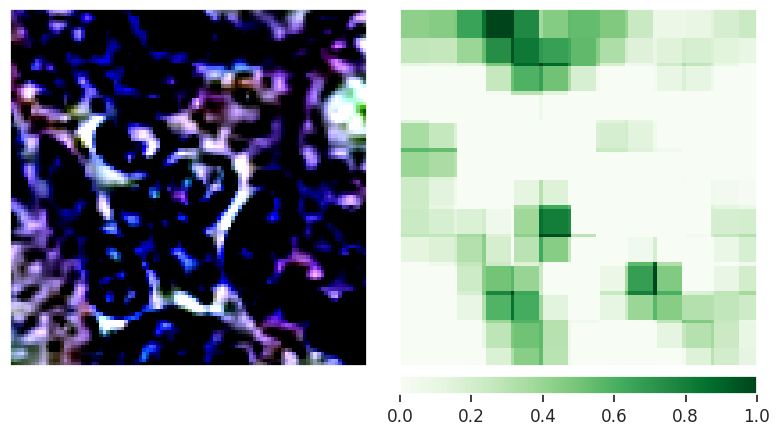

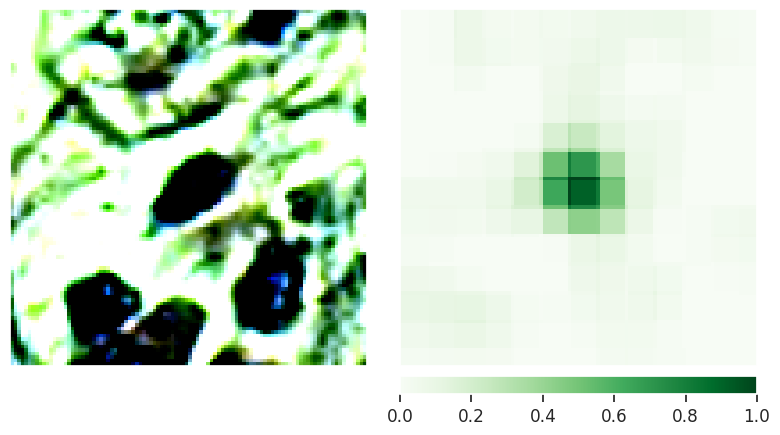

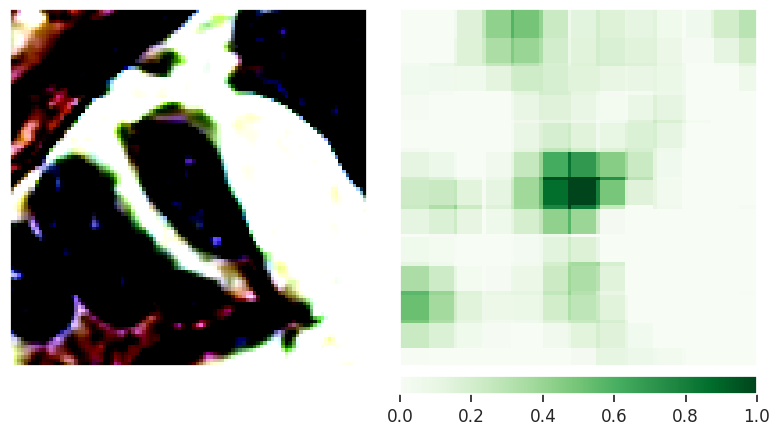

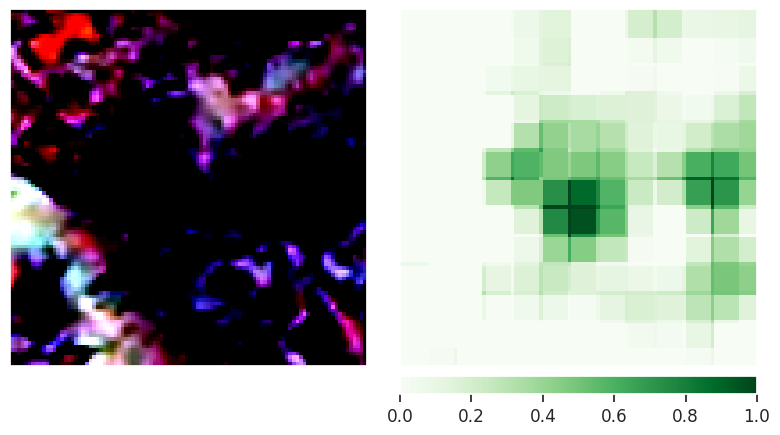

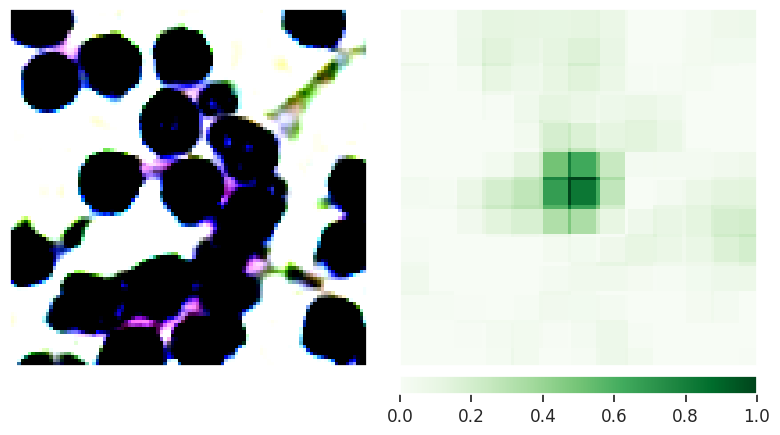

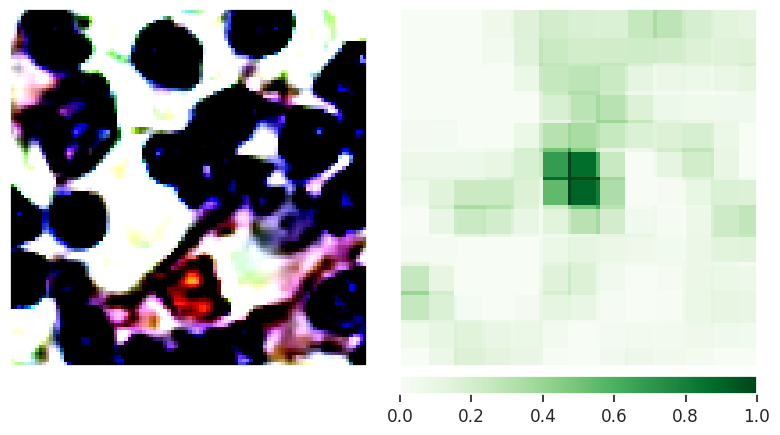

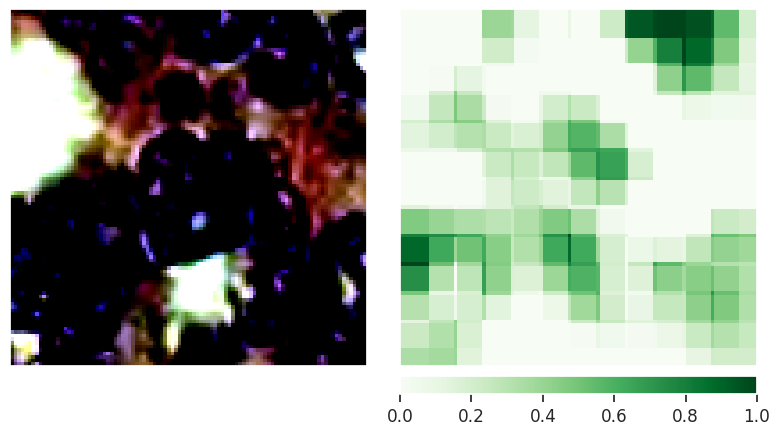

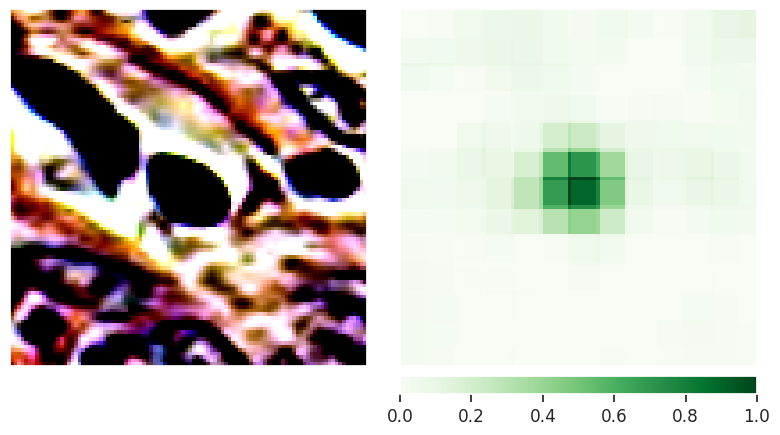

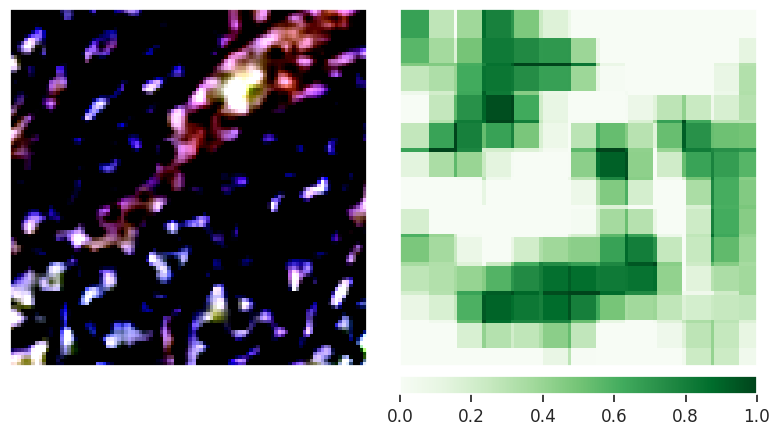

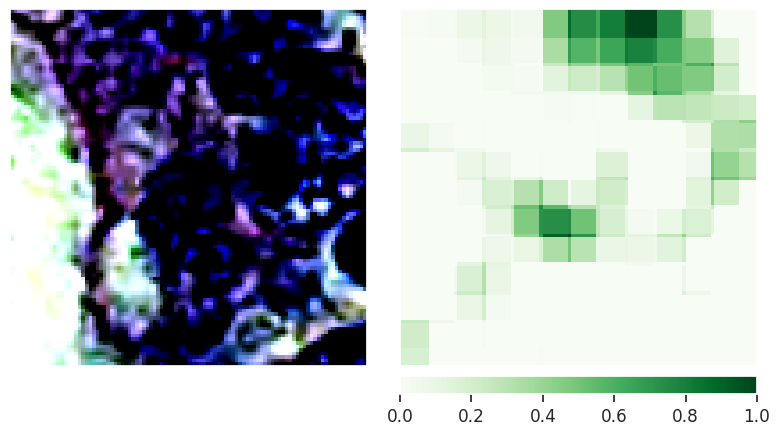

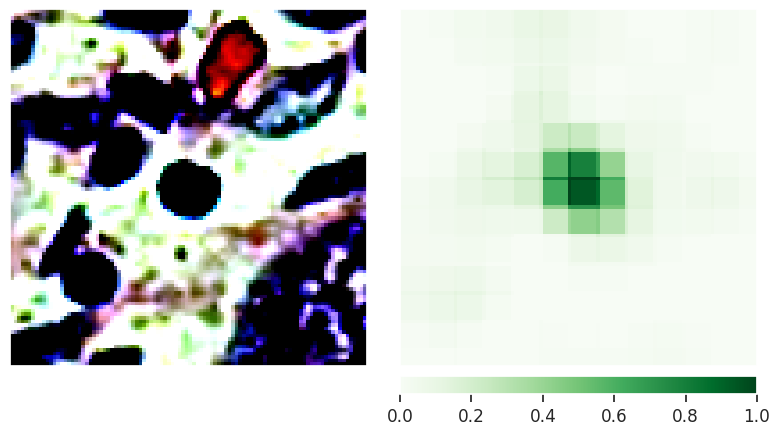

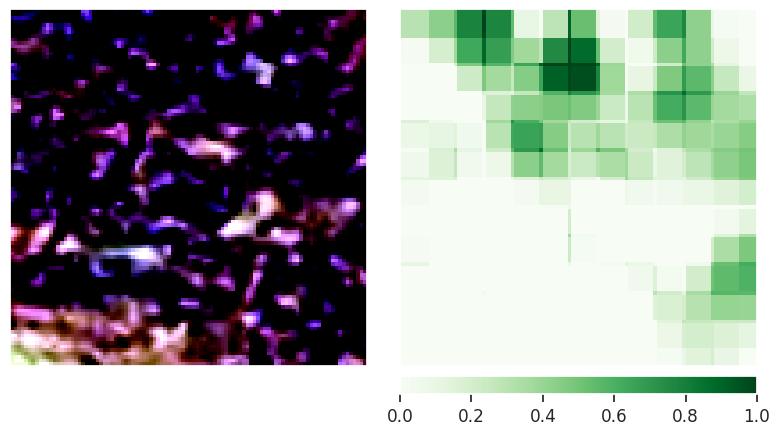

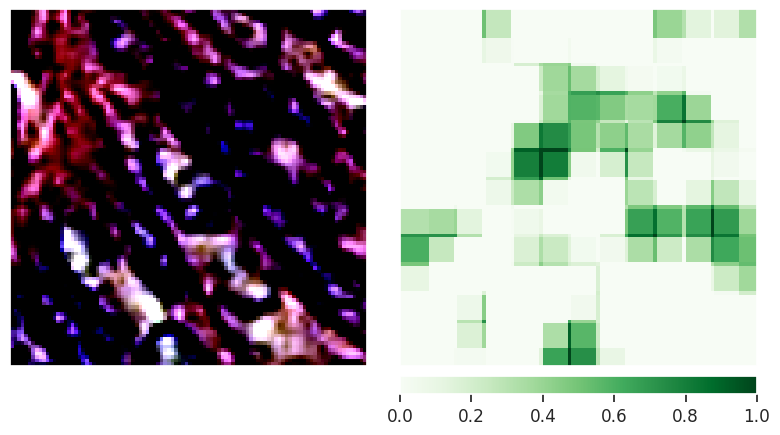

In [192]:
occlusion = Occlusion(model)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        val_pred = output.argmax(dim=1, keepdim=True)
        val_preds = val_pred.flatten().tolist()
        attributions_occ = occlusion.attribute(
            images,
            strides=(3, 8, 8),
            target=val_preds,
            sliding_window_shapes=(3,15, 15),
            baselines=0
        )
        break
    for i in range(len(attributions_occ)):
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ[i].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(images[i].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

As can be seen from the first batch of images, the darker the green a block is, the more important it is in determining the type of cell.

### Model 2 (ResNet50)

ResNet50 was chosen as the pre-trained model, which was trained on using transfer learning for this specific task. The pretrained model was downloaded and the final layer of the model was modified. The last layer performs a linear transformation to convert the number of `in_features` to the number of labels, i.e., 4.

The code snippet below demonstrates the initialization of the model:

```
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)
```


In [9]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "batch_size": tune.choice([16,32,64]),
        "lr": tune.choice([0.01,0.001,0.0001]),
        "weight_decay": tune.choice([0.00001,0.001,0.1,0]),
        "momentum": tune.choice([0.99,0.9,0.5,0]),
        }
    
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )
    
    reporter = CLIReporter(
        parameter_columns=["batch_size", "lr", "weight_decay", "momentum"],
        metric_columns=["loss", "accuracy", "training_iteration"]
    )
    
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 4)
    
    result = tune.run(
        partial(
            trainer_raytune,
            model = model,
            train_dataset=train_dataset,
            val_dataset=val_dataset
        ),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
            best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
            best_trial.last_result["accuracy"]))

    best_trained_model = create_new_model()
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
            best_checkpoint_dir, "checkpoint"))

if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    best_trained_model = main(num_samples=10, max_num_epochs=15, gpus_per_trial=0.5)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

NameError: name 'trainer_raytune' is not defined

*NOTE: The error in the above cell occured because the block was run not in the correct order. It was run after all GPU acceleration had been exhausted so it could not be run again to completion. However, the resultant best configuration is used in the next block.*

#### Training on the Best Configuration for Model 2

The model was trained and evaluated on the best configuration. Losses and accuracies were plotted and the confusion matrix was constructed. The best configuration was:

* `batch_size`: 16
* `lr`: 0.001
* `weight_decay`: 0
* `momentum`: 0.9

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1, Train Loss: 0.382, Train Accuracy: 86.357, Validation Loss: 0.142, Validation Accuracy: 95.106
Epoch: 2, Train Loss: 0.114, Train Accuracy: 96.504, Validation Loss: 0.099, Validation Accuracy: 96.561
Epoch: 3, Train Loss: 0.049, Train Accuracy: 98.677, Validation Loss: 0.082, Validation Accuracy: 97.178
Epoch: 4, Train Loss: 0.038, Train Accuracy: 98.923, Validation Loss: 0.077, Validation Accuracy: 97.531
Epoch: 5, Train Loss: 0.019, Train Accuracy: 99.471, Validation Loss: 0.073, Validation Accuracy: 97.751
Epoch: 6, Train Loss: 0.026, Train Accuracy: 99.282, Validation Loss: 0.080, Validation Accuracy: 97.222
Epoch: 7, Train Loss: 0.016, Train Accuracy: 99.622, Validation Loss: 0.079, Validation Accuracy: 97.399
Epoch: 8, Train Loss: 0.011, Train Accuracy: 99.717, Validation Loss: 0.090, Validation Accuracy: 97.443
Epoch: 9, Train Loss: 0.009, Train Accuracy: 99.754, Validation Loss: 0.076, Validation Accuracy: 97.619
Epoch: 10, Train Loss: 0.008, Train Accuracy: 99.868, V

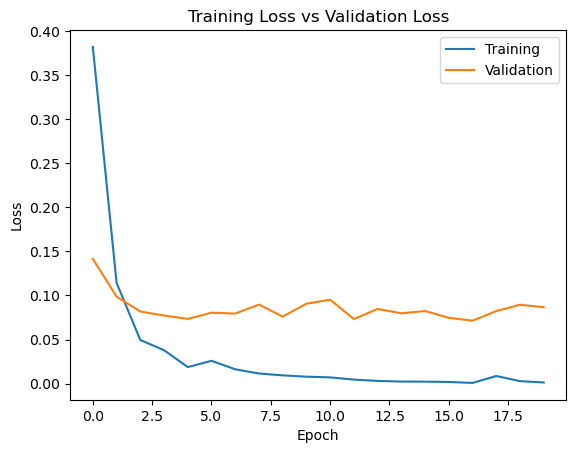

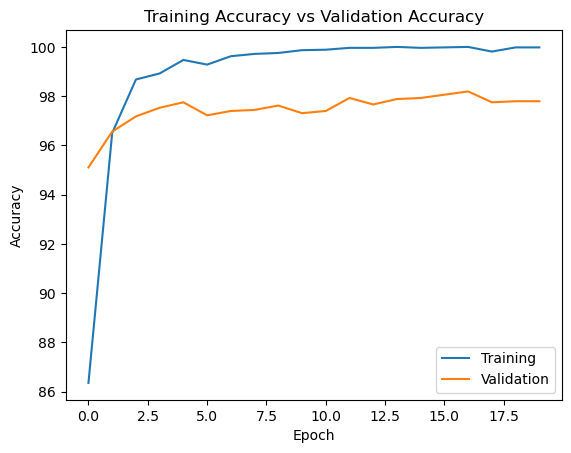

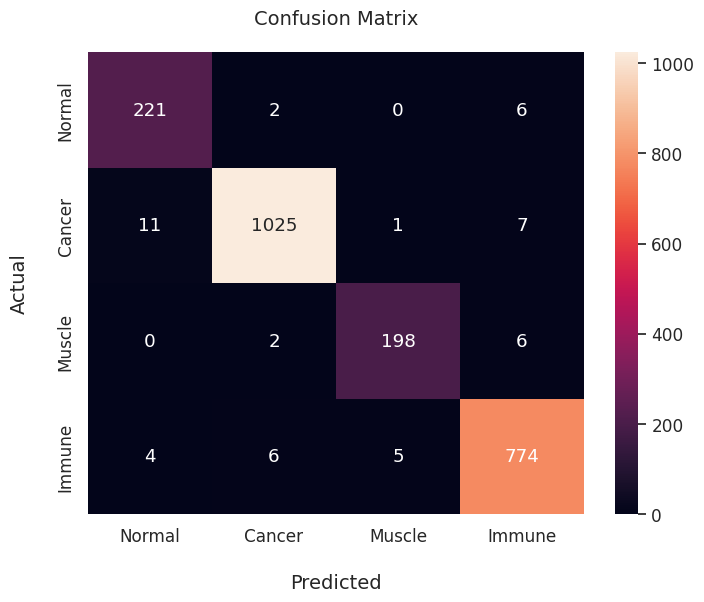

In [10]:
best_config = {
    'batch_size': 16,
    'lr': 0.001,
    'weight_decay': 0,
    'momentum': 0.9
}

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)

trainer(
    model = model,
    device = device,
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    n_epochs = 10,
    batch_size = best_config['batch_size'],
    lr = best_config['lr'],
    weight_decay=best_config['weight_decay'],
    momentum=best_config['momentum']
)

As expected, the training loss decreases and the training accuracy increases as the number of epochs increase. The validation loss oscillates at the same y-value, while the validation accuracy slowly seems to increase. The confusion matrix shows an extremely well classified model with very few errors. This shows the power of using a pre-trained model.

#### Occlusion-Based Attribution Using Captum on Model 2

Model 2 was also observed similarly on the first batch.

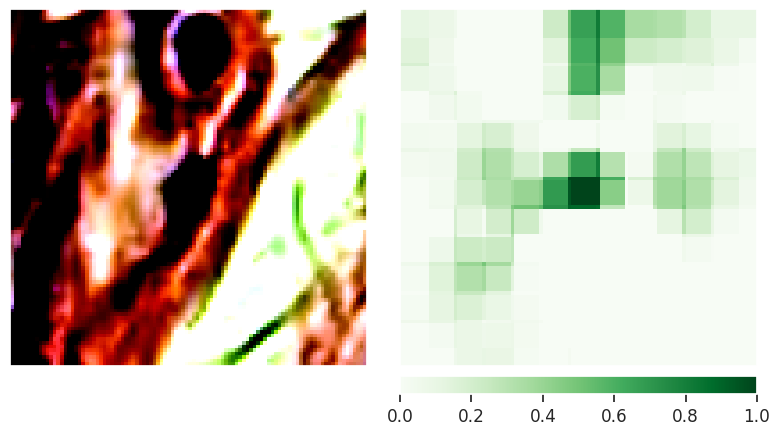

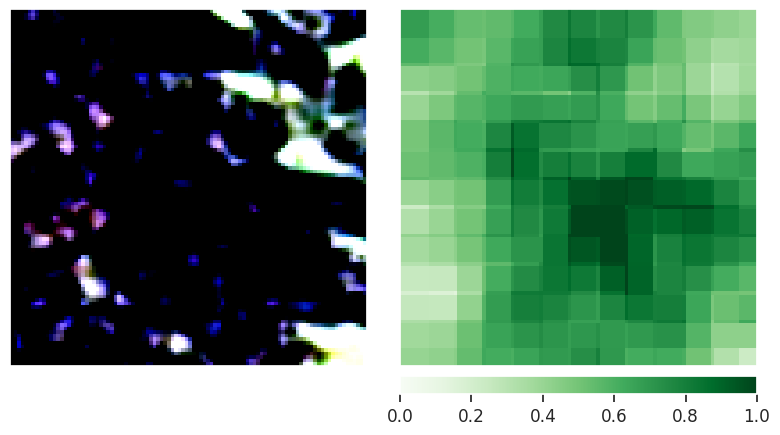

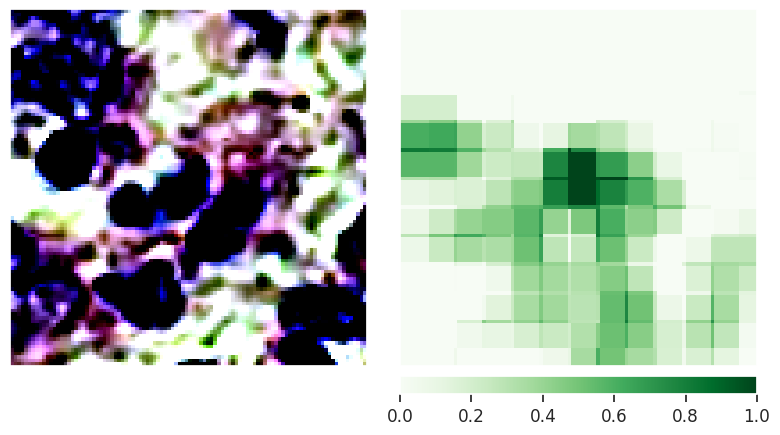

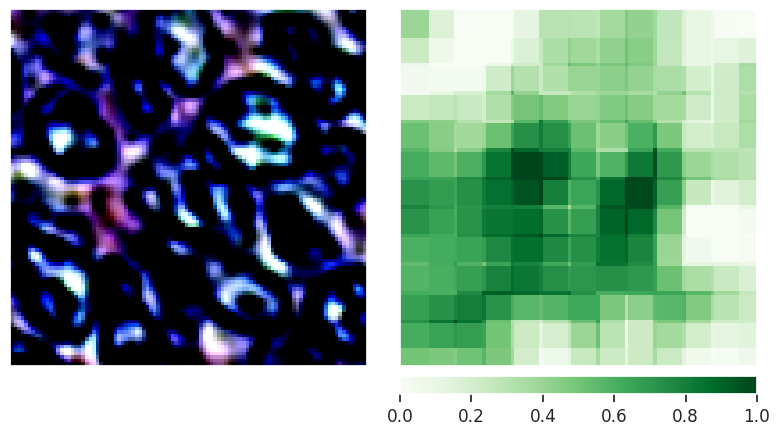

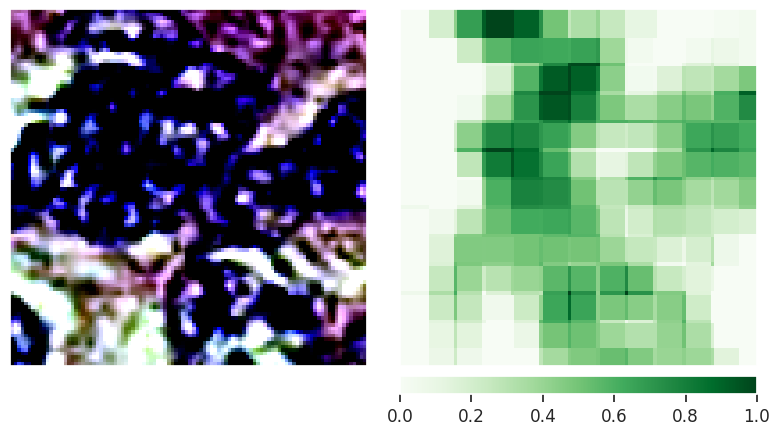

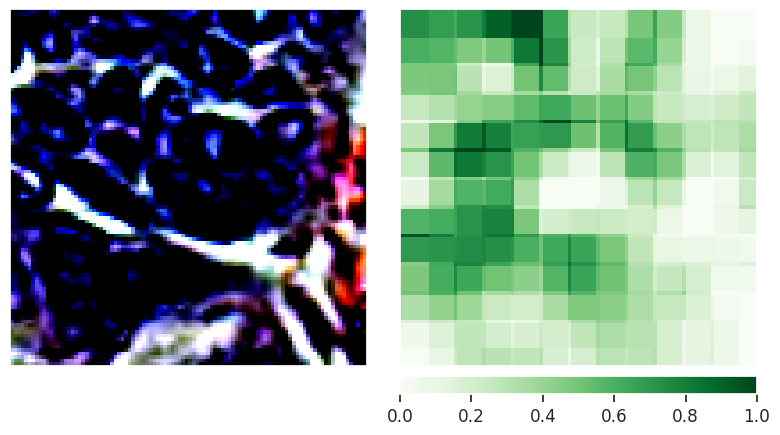

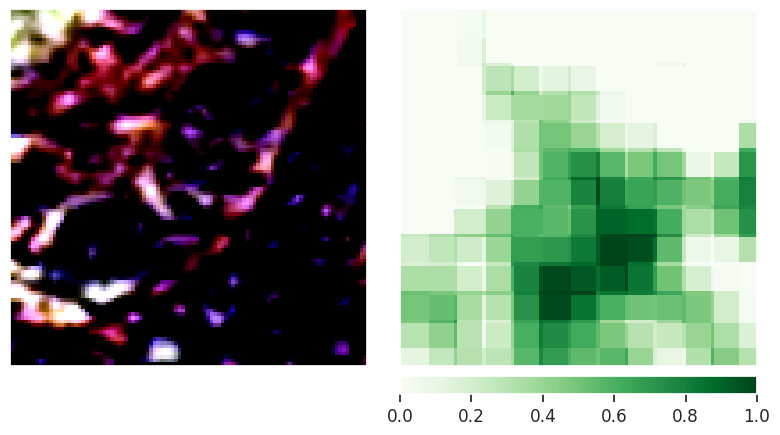

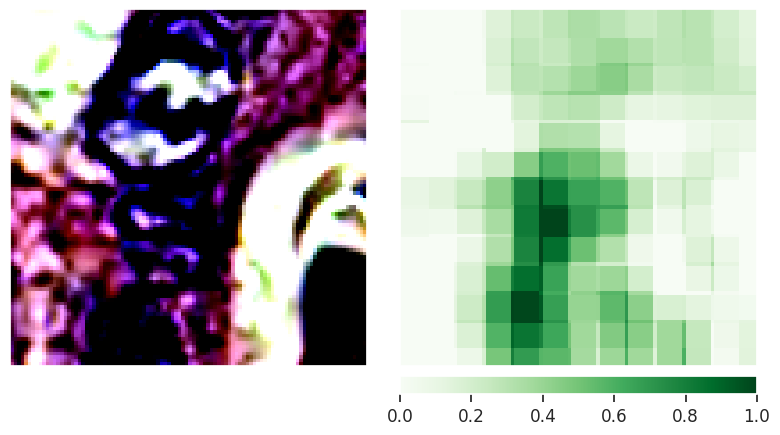

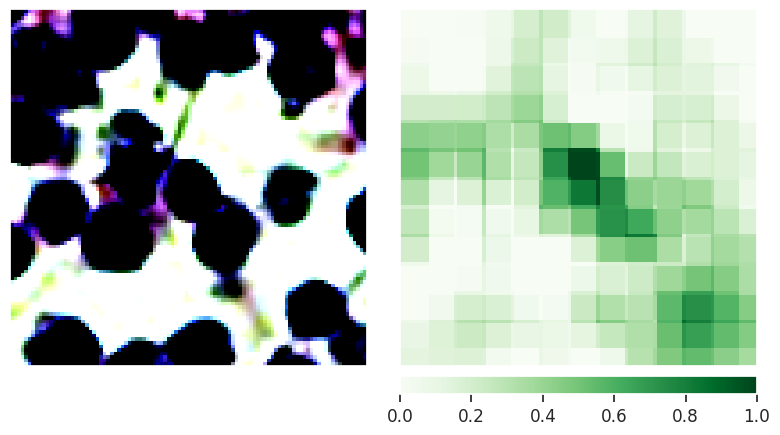

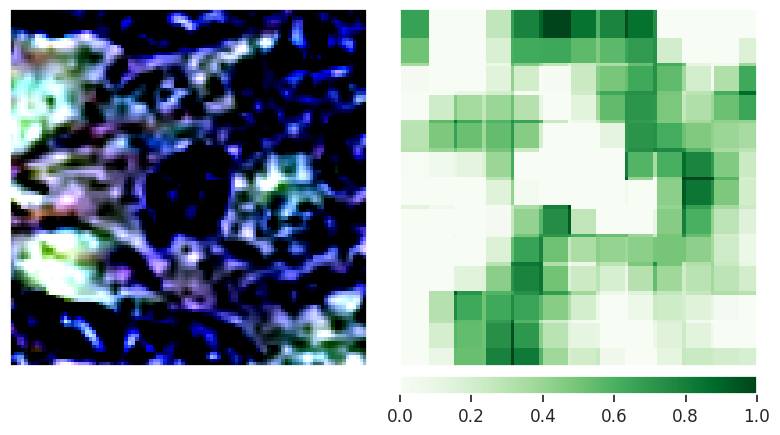

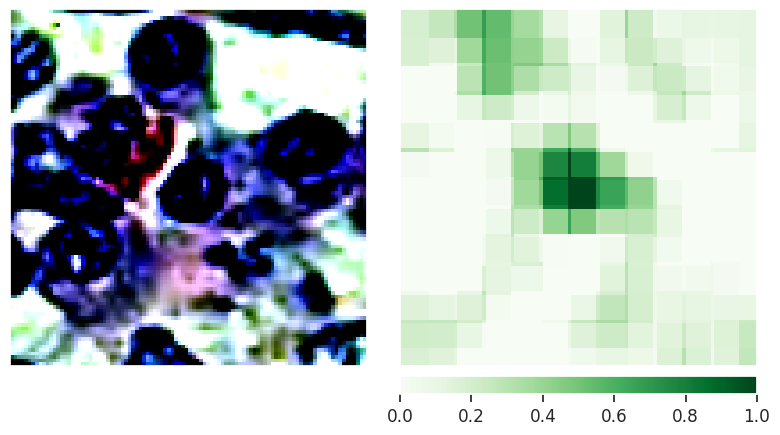

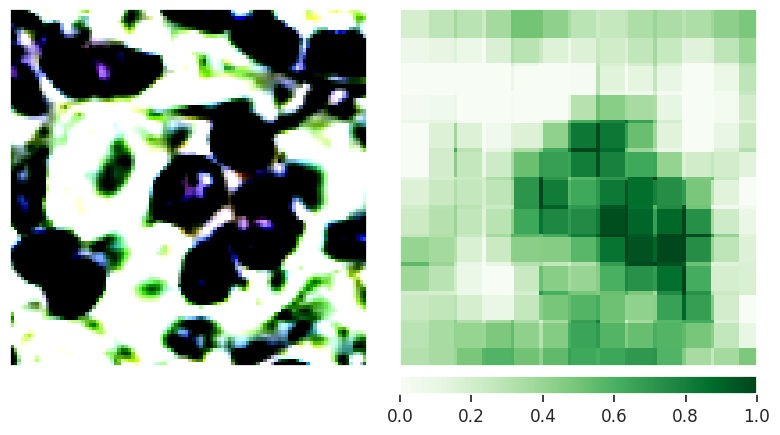

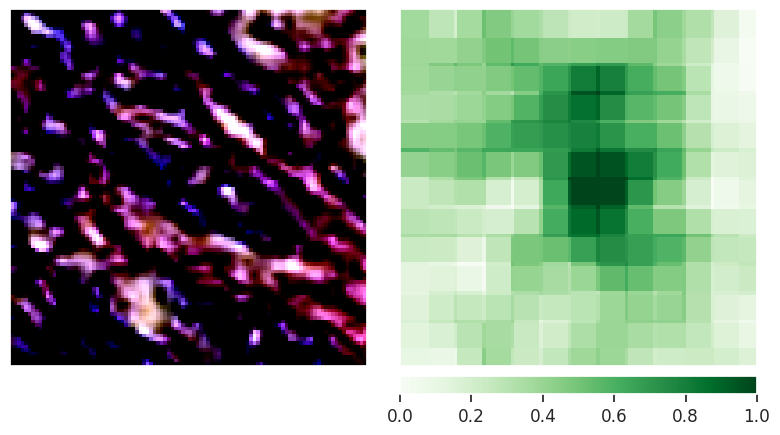

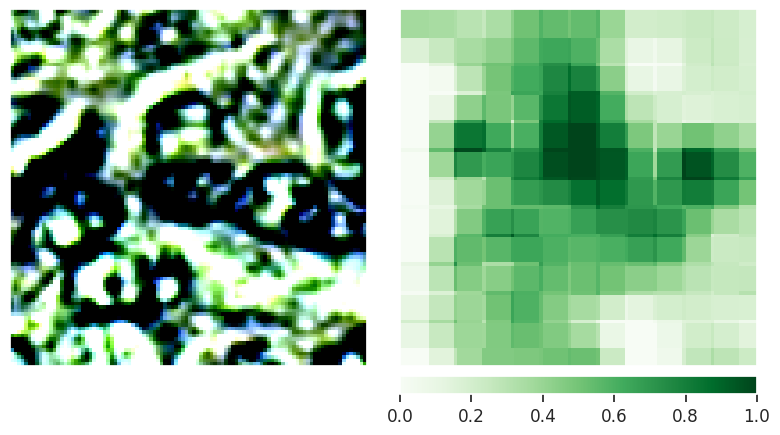

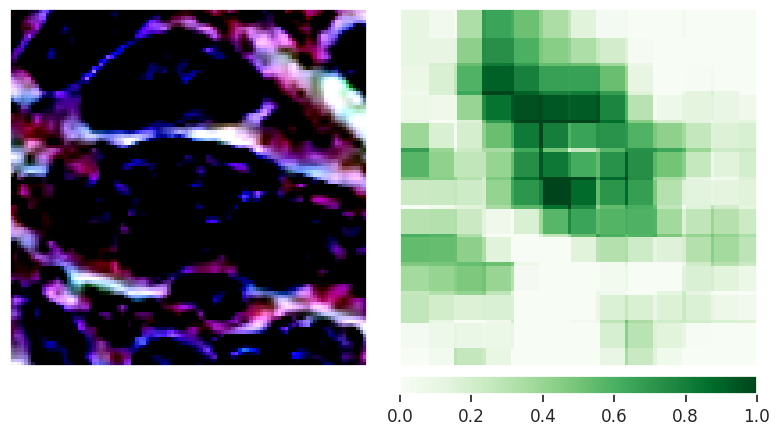

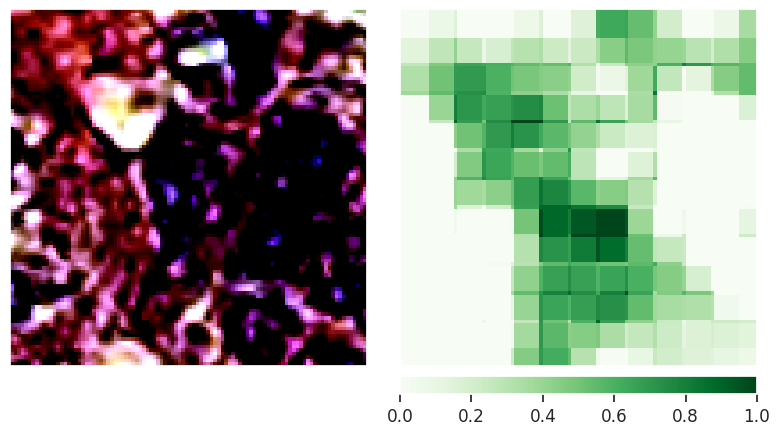

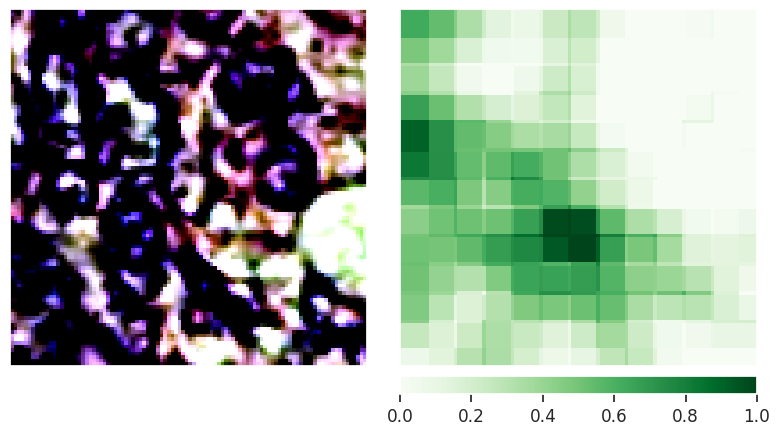

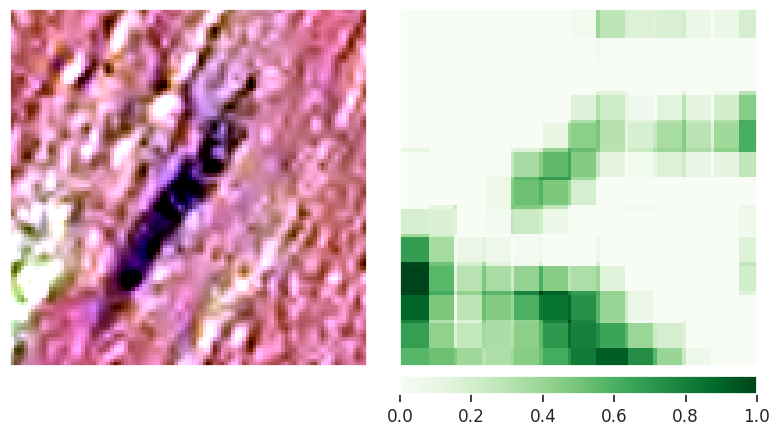

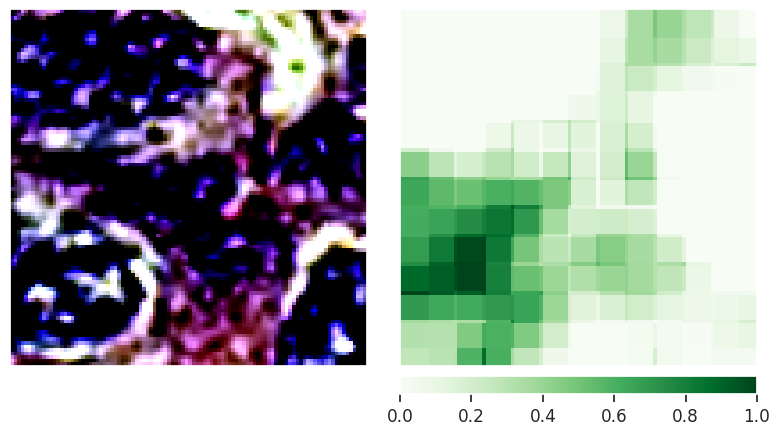

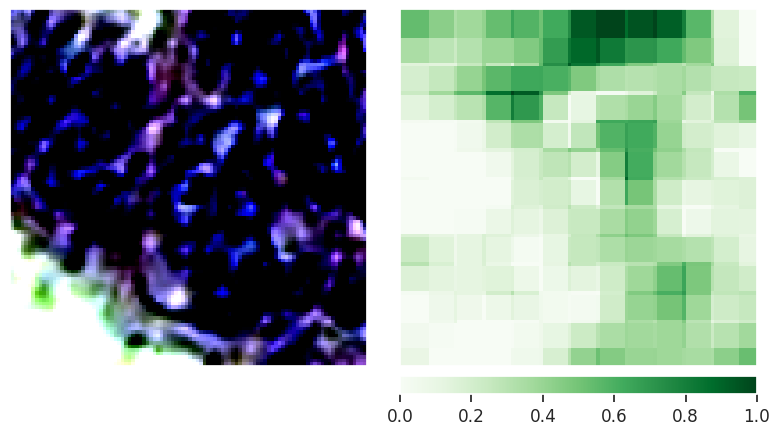

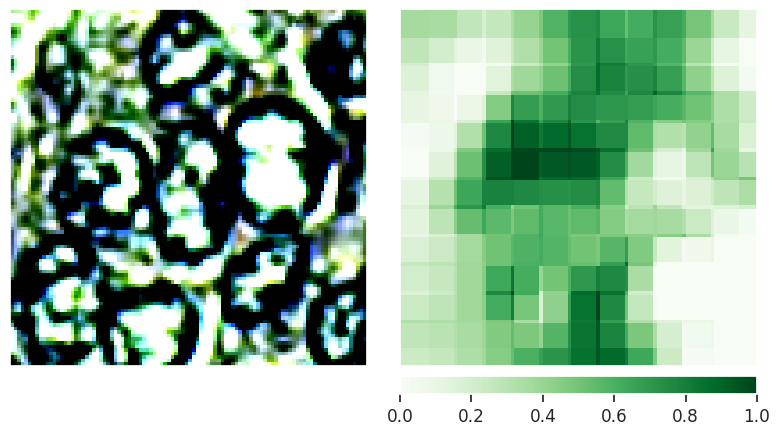

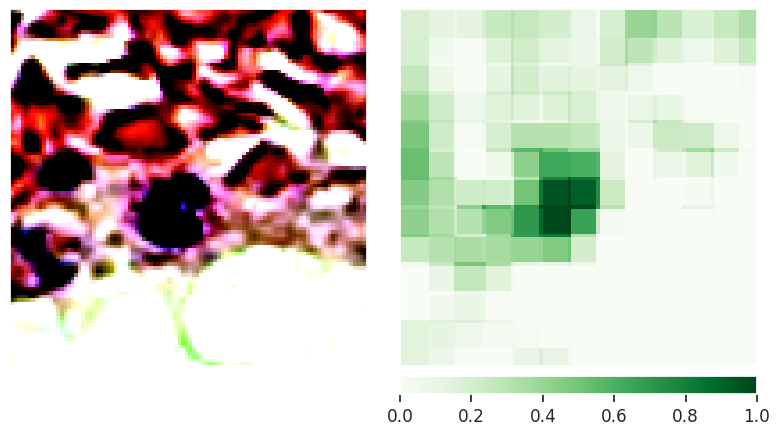

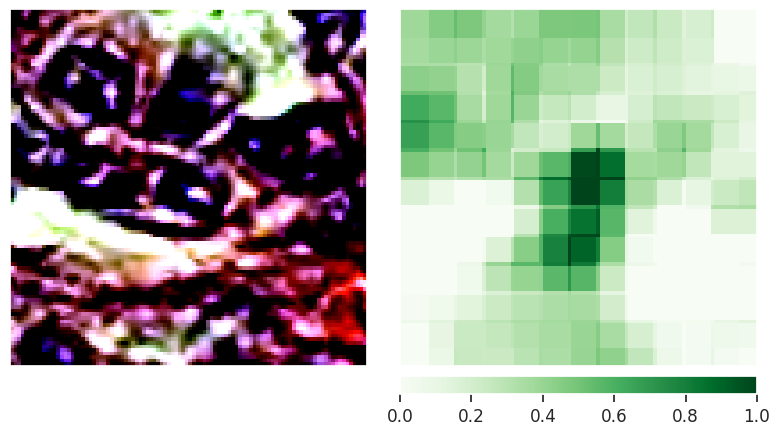

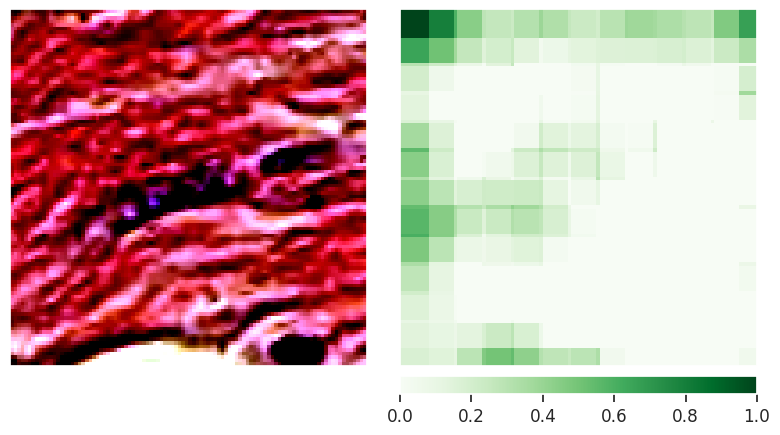

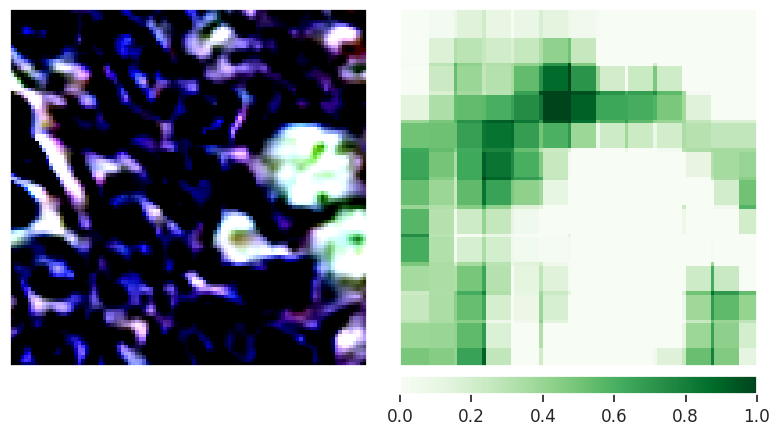

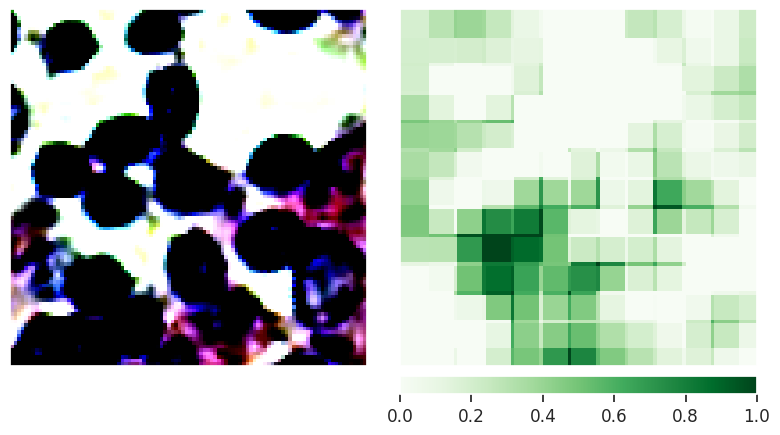

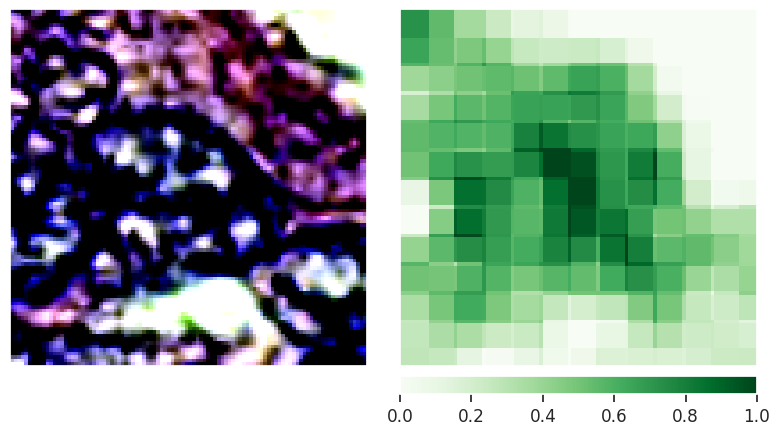

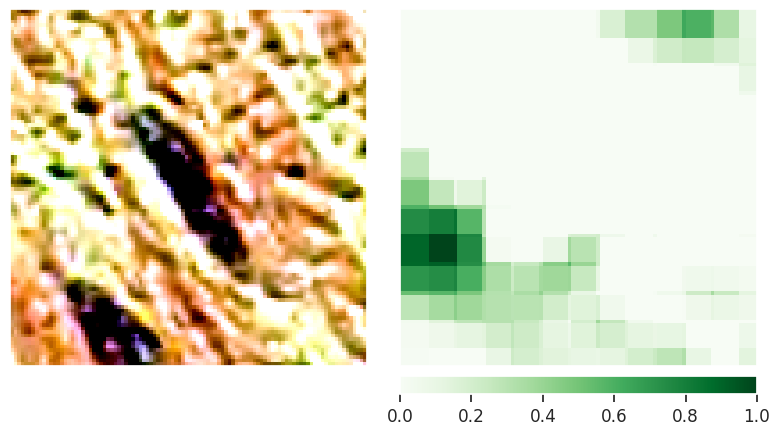

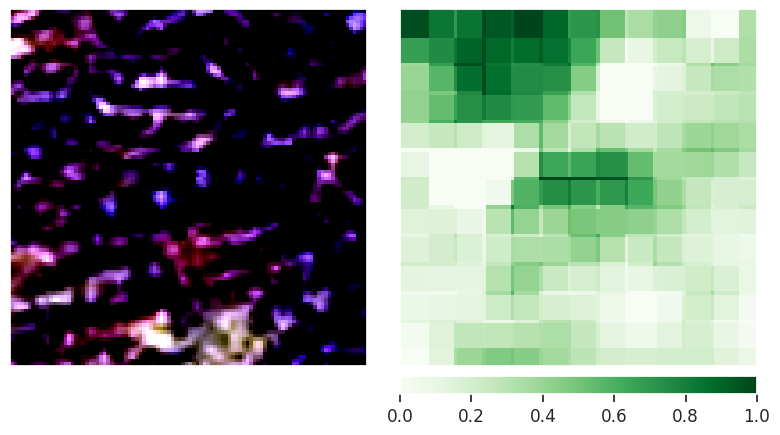

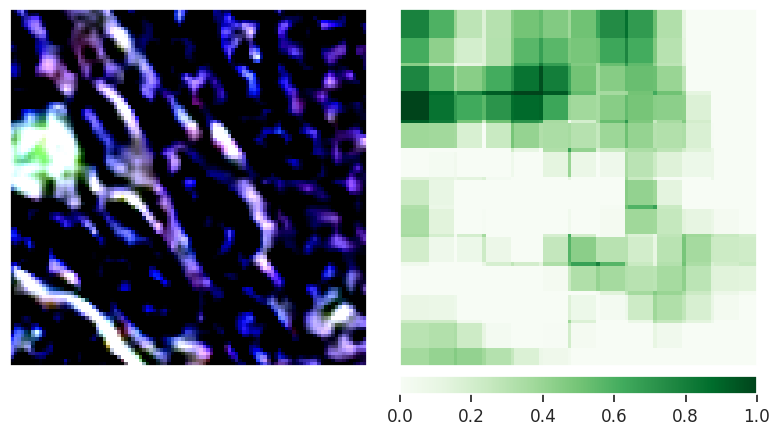

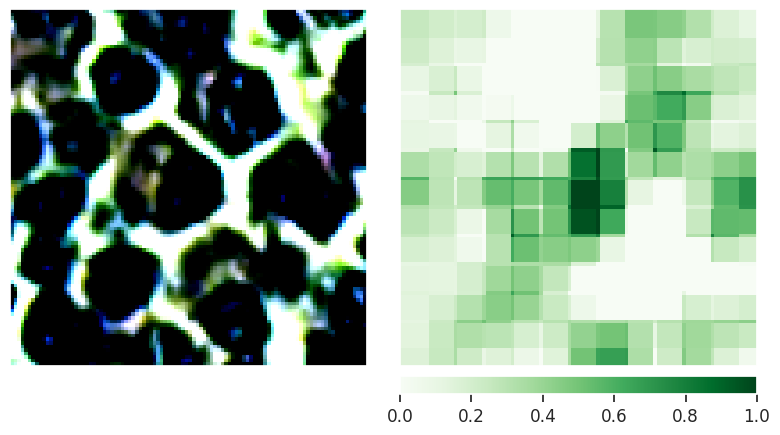

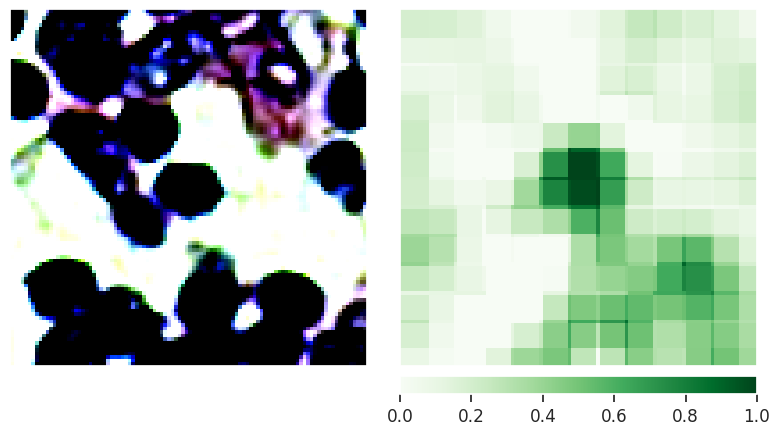

In [40]:
occlusion = Occlusion(model)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        val_pred = output.argmax(dim=1, keepdim=True)
        val_preds = val_pred.flatten().tolist()
        attributions_occ = occlusion.attribute(
            images,
            strides=(3, 8, 8),
            target=val_preds,
            sliding_window_shapes=(3,15, 15),
            baselines=0
        )
        break
    for i in range(len(attributions_occ)):
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ[i].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(images[i].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

The darker the green color of the block, the more important that section of the image is for the classifier to make a decision.

### Test and Submit the Best Model

The ResNet50 model outperformed the from-scratch model by a long shot. It was tested on the test set and the result was uploaded to Kaggle.

In [ ]:
perform_test(model)